<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Semantic_segmentation_dermoscopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation

In [ ]:
%%capture
!pip install wandb kaggle

## imports

In [ ]:
import gc
#import kaggle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import wandb


from google.colab import userdata, files
from matplotlib import rcParams
from skimage.io import imread
from skimage.transform import resize
from time import time
from torch.utils.data import DataLoader
from torchvision import models
from typing import Callable, List, Dict, Tuple

from IPython.display import clear_output

In [ ]:
rcParams['figure.figsize'] = (15,4)

## Download and unzip dataset

In [ ]:
try:
  !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
  if 'PH2Dataset.rar' in os.listdir():
    get_ipython().system_raw("unrar x PH2Dataset.rar")
  else:
    raise Exception
except Exception as e:
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d kanametov/ph2dataset
  !unzip -q ph2dataset.zip
  current_folder_path = '/content/PH2Dataset/PH2_Dataset'
  new_folder_path = '/content/PH2Dataset/PH2 Dataset images'
  os.rename(current_folder_path, new_folder_path)

--2023-11-19 23:22:02--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-11-19 23:22:02--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf8ac4f938c3569d5f803b6a74e.dl.dropboxusercontent.com/cd/0/inline/CH234qHwAo4I15jNm_PF0kUiguzYRiL9PrwpkcEsYVqu_WCuM-SqqIE1g5QxwrhZGvREB2HDvyLE0RfgDqpLtMM6vzgH3ILcfs25kApKFhXouKeEZPo6NtU9alY9RrKkb2U/file# [following]
--2023-11-19 23:22:03--  https://ucf8ac4f938c3569d5f803b6a74e.dl.dropboxusercontent.com/cd/0/inline/CH234qHwAo4I15jNm_PF0kUiguzYRiL9PrwpkcEsYVqu_WCuM-SqqIE1g5QxwrhZGvREB2HDvyLE0RfgDqpLtMM6vzgH3ILcfs25kApKFhXouKeEZP

In [ ]:
images = []
lesions = []

for root, dirs, files in os.walk(os.path.join('PH2Dataset', 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

## Set config

In [8]:
class CFG:
  batch_size = 16
  out_channels = 64
  batch_norm_momentum = 0.1
  seed = 42
  device = lambda: torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  loss = lambda: 'dice'
  lr = 1e-4
  epochs=40
  w_decay = 3e-2
  eps = 1e-8
  wandbapi = False
  best_model = float('inf')
  best_model_path = 'best_model.pth'

wandb_config = lambda: {
    'achitecture':'SegNet',
    'activation':'relu',
    'optimizer':'AdamW',
    'lr':CFG.lr,
    #'lr_scheduler_step': 5,
    'loss': CFG.loss(),
    'batch_size':CFG.batch_size,
    'device':CFG.device(),
}

def get_scheduler(opt):
  return torch.optim.lr_scheduler.MultiStepLR(opt, gamma=0.8,
                                              milestones=[CFG.epochs // 3,
                                                          CFG.epochs // 2,
                                                          CFG.epochs // 1.4,
                                                          CFG.epochs // 1.1])

def get_optimizer(model):
  return torch.optim.AdamW(model.parameters(), lr = CFG.lr, eps=CFG.eps,
                           weight_decay=CFG.w_decay, amsgrad=True)

In [ ]:
try:
    CFG.wandbapi = userdata.get('wandb')
    project="Semantic_segmentation_dermoscopic"
    entity='dimildizio'
    wandb.login(key=CFG.wandbapi)

except Exception as e:
  print(e)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def wandb_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for integrating with Weights & Biases (wandb).

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        print('wrapper works')
        if CFG.wandbapi:
            wandb.init(project=project, entity=entity, config=wandb_config())
            print('Logging wandb')
        try:
          result = func(*args, **kwargs)
        except Exception as e:
          if CFG.wandbapi:
            wandb.log({"error_message": str(e)}, commit=False)
            wandb.finish()
          raise e
        finally:
          if CFG.wandbapi:
            wandb.finish()
        return result
    return wrapped_function

### Freeze seeds

In [ ]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

In [ ]:
def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [ ]:
seed_everything()

## Dataset

### Resize and transform

In [ ]:
size = (256, 256)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions], np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


### Preview images

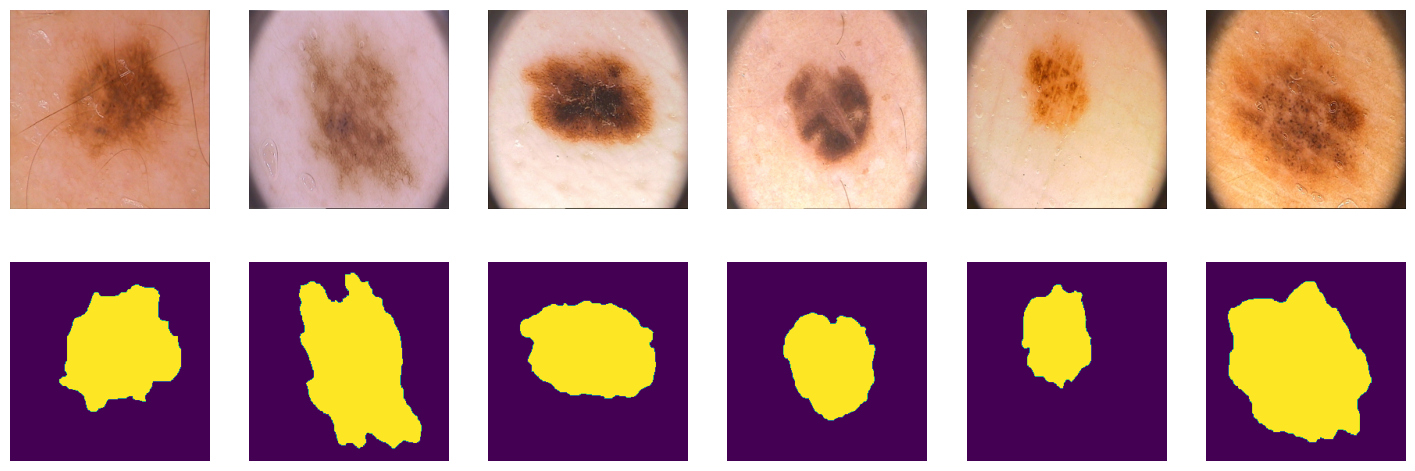

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Split indexes

In [ ]:
@seed_wrapper
def tvt_split_custom(X):
  idx = np.random.choice(len(X), len(X), False)
  return np.split(idx, [100, 150])

In [ ]:
train, val, test = tvt_split_custom(X)

### Create dataloaders

In [ ]:
def match_idxs(idx: np.ndarray, xs: np.ndarray = X, ys: np.ndarray = Y) -> list:
    """
    Match indices and create a list of tuples.

    Parameters:
    - idx: np.ndarray
        An array of indices.
    - xs: np.ndarray, optional
        The input array for x (default value X).
    - ys: np.ndarray, optional
        The input array for y (default value Y).

    Returns:
    - list
        A list of tuples created by matching indices.
    """
    x = np.moveaxis(xs[idx], source=3, destination=1)
    y = ys[idx, np.newaxis]
    new_array = list(zip(x, y))
    return new_array

In [ ]:
data_train = DataLoader(match_idxs(train), batch_size=CFG.batch_size, shuffle=True)
data_val = DataLoader(match_idxs(val), batch_size=CFG.batch_size, shuffle=True)
data_test = DataLoader(match_idxs(test), batch_size=CFG.batch_size, shuffle=False)


## SegNet

![picture](https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Convolutions/data/segnet_pic.png)
----------------------------------------------------------------------------------------


* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

We're going to write a model similar to the one obe but with some differences, mainly - there's going to be a bottleneck layer beween the last pooling and first upsampling and there also won't be softmax (first of all because softmax is for multiclass classification, lol, and sigmoid - for binary) in the end, we'll have loss and metrics calculate probabilities.

In [ ]:
class SegNet(nn.Module):
    def __init__(self, inch=3):
        super().__init__()

        # encoder (downsampling)
        # down_0
        ouch_0 = CFG.out_channels
        self.encoder_conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=inch, out_channels=ouch_0, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_0, out_channels=ouch_0, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            )

        self.pool_0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        # down_1
        ouch_1 = ouch_0 * 2
        self.encoder_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_0, out_channels=ouch_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
        )
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        # down_2
        ouch_2 = ouch_1 * 2
        self.encoder_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )
        self.pool_2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        # down_3
        ouch_3=ouch_2 * 2
        self.encoder_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_decoder =  nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # decoder (upsampling)
        # up_1
        self.upsample_0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.decoder_conv_0 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_2,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # up_2
        self.upsample_1 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.decoder_conv_1 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_1,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # up_3
        self.upsample_2 =  nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.decoder_conv_2 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_1, out_channels=ouch_1,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_0,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
          )

        # up_4
        self.upsample_3 =  nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.decoder_conv_3 =nn.Sequential(
          nn.Conv2d(in_channels=ouch_0, out_channels=ouch_0,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_0, out_channels=1,
                      kernel_size=3, padding=1)
          ) # no activation


    def forward(self, x):
        # encoder
        e_0, idx_0 = self.pool_0(self.encoder_conv_0(x))
        e_1, idx_1 = self.pool_1(self.encoder_conv_1(e_0))
        e_2, idx_2 = self.pool_2(self.encoder_conv_2(e_1))
        e_3, idx_3 = self.pool_3(self.encoder_conv_3(e_2))

        # bottleneck
        b_e, idx_b = self.bottleneck_pool(self.bottleneck_conv(e_3))
        b_d = self.bottleneck_decoder(self.bottleneck_upsample(b_e, idx_b))

        # decoder
        d_0 = self.decoder_conv_0(self.upsample_0(b_d, idx_3))
        d_1 = self.decoder_conv_1(self.upsample_1(d_0, idx_2))
        d_2 = self.decoder_conv_2(self.upsample_2(d_1, idx_1))
        d_3 = self.decoder_conv_3(self.upsample_3(d_2, idx_0))
        return d_3

In [ ]:
print(summary(SegNet(), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Metrics

Here we utilize IoU metrics:


$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$$

So, for example is we have two matrices:

real (y):

         0  1  2
      0 [1, 0, 0]
      1 [0, 1, 0]
      2 [0, 0, 1]

predicted ($\hat{y}$):

        0  1  2
     0 [1, 1, 0]
     1 [0, 1, 0]
     2 [0, 1, 0]

our intersection of ones(!) would look like that, so the sum is **2**:


        0  1  2
     0 [1, 0, 0]
     1 [0, 1, 0]
     2 [0, 0, 0]


and the union would be the sum of all unique places where there are ones at positions, so the result is **5**:

        0  1  2
     0 [1, 1, 0]
     1 [0, 1, 0]
     2 [0, 1, 1]

and in the end we get $$IoU=\frac{ y \cap \hat{y}}{y \cup \hat{y}} = \frac{2}{5}$$

Let's say we got the real values and the prediction:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

Then the intersection and union should be:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

#### Implementing IoU

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = torch.sigmoid(outputs) > 0.5
    outputs = outputs.to('cpu').byte()
    labels = labels.to('cpu').byte()

    SMOOTH = 1e-8

    intersection_total = 0
    union_total = 0
    for i in range(outputs.size(0)):
        intersection = (outputs[i] & labels[i]).float().sum()
        union = (outputs[i] | labels[i]).float().sum()

        intersection_total += intersection
        union_total += union
    iou = (intersection_total + SMOOTH) / (union_total + SMOOTH)
    return iou

## BCE Loss

The common equation for BCE loss is: $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$


In [ ]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def standard_torch_bce_loss(y_hat, y):
  # torch.nn.functional for comparison
  loss = nn.functional.binary_cross_entropy_with_logits(y_hat, y.float())
  return loss

def standard_bce_loss(y_hat, y, epsilon=1e-10):
    # Standard Binary Cross-Entropy Loss
    y_hat = sigmoid(y_hat) + epsilon
    loss = -torch.mean(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    return loss


# Example usage:
y_hat = torch.tensor([1.5, 1.5, 2.5])
y = torch.tensor([0, 1, 0], dtype=torch.float32)


print("Standard BCE Loss (Torch):", standard_torch_bce_loss(y_hat, y))
print("Standard BCE Loss (Custom):", standard_bce_loss(y_hat, y))

Standard BCE Loss (Torch): tensor(1.4939)
Standard BCE Loss (Custom): tensor(1.4939)


Due to logarithm of number below 1 and to how sigmoid for probability works: $$\frac{1}{1+\exp(-x)}$$  

One over exponent of very large logits (regardless if negative or postive) results in numerical instability

In [ ]:
def check_bce(func, func_name):
  print(f"{func_name}:")
  for nums in ((-1000.0, -1000.0, -2000.0), (1000.0, 1000.0, 2000.0)):
    y_hat_large = torch.tensor([nums[0], nums[1], nums[2]]) # would be the same for negative numbers
    y_large = torch.tensor([0, 1, 1])
    sign = 'positive' if sum(nums) > 0 else 'negative'
    print(f'\tLarge {sign} numbers: {func(y_hat_large, y_large)}')
  print()

In [ ]:
check_bce(standard_torch_bce_loss, "Standard BCE Loss (Torch)")
check_bce(standard_bce_loss, "Standard BCE Loss (Custom)")

Standard BCE Loss (Torch):
	Large negative numbers: 1000.0
	Large positive numbers: 333.3333435058594

Standard BCE Loss (Custom):
	Large negative numbers: 15.350566864013672
	Large positive numbers: nan



As it's shown above custom loss cannot deal with numerical instability well and adding a small (1e-10) number epsilon doesn't help (without it the result on large negative numbers would be nan as well).

#### Log-sum-exp trick

To introduce numerical stability we rely on the fact that exp(x) gorws rapidly, and performing the opposite operation - taking logarithm would help avoid under- or over-flow. $$log(1+exp(- |\hat y|)) $$

Then we perform element-wise $max(\hat y , 0)$ which makes them all non-negative values to avoid said num.instability since *log of negative number is undefined*.

We also create $α$ which is $max(\hat y , 0)$ above serving as **margin**( that states that the model is not penalized if the prediction is beyond those values) and $\hat y \cdot y$ - element-wise multiplication of prediction by real values. If they have the same sign - prediction would  be positive, othewise - negative (error) and the model will be penalized by the **margin** size. $$max(\hat y , 0) - \hat y \cdot y$$


So gathering it together we get:  $$\mathcal L_{BCE}(y, \hat y) = max(\hat y , 0) - \hat y \cdot y + log(1+exp(- |\hat y|)) $$

In [ ]:
def num_stab_bce_loss(y_hat, y):
    # Numerical stability using log-sum-exp trick
    max_val = torch.max(y_hat, torch.tensor(0.0))
    loss = torch.mean(max_val - y_hat * y + torch.log(1 + torch.exp(-torch.abs(y_hat))))
    return loss

In [ ]:
check_bce(standard_torch_bce_loss, "Standard BCE Loss (Torch)")
check_bce(standard_bce_loss, "Standard BCE Loss (Custom)")
check_bce(num_stab_bce_loss, 'Num.Stab BCE Loss (Custom)')

Standard BCE Loss (Torch):
	Large negative numbers: 1000.0
	Large positive numbers: 333.3333435058594

Standard BCE Loss (Custom):
	Large negative numbers: 15.350566864013672
	Large positive numbers: nan

Num.Stab BCE Loss (Custom):
	Large negative numbers: 1000.0
	Large positive numbers: 333.3333435058594



#### Bathe in tests

In [ ]:
s1 = torch.randn(10, 3, 256, 256)
s2 = torch.randn(10, 3, 256, 256)

torch_bce_result = nn.BCEWithLogitsLoss()(s1, s2)
custom_bce_result= num_stab_bce_loss(s1, s2)

#round to 1e-6 since the float is a float after all and can get crazy at ~1e-10 values
assert round(torch_bce_result.item(), 6) == round(custom_bce_result.item(), 6)
print(torch_bce_result, custom_bce_result)

tensor(0.8059) tensor(0.8059)


## Training process

In [ ]:
@wandb_wrapper
@seed_wrapper
def train(model, loss_fn, train_loader, val_loader):
  epochs = CFG.epochs # not argiment since args are set upon func def not a call
  optimizer = get_optimizer(model)
  scheduler = get_scheduler(optimizer)
  best_state_model = None
  best_val_score = 0.0

  history = {'train':{'loss':[], 'score':[]},
             'val':{'loss':[], 'score':[]},}

  for epoch in range(epochs):
    tic = time()
    print(f'* Epoch: {epoch+1}/{epochs}')
    avg_train_loss, avg_train_score = train_epoch(model, optimizer,
                                                  loss_fn, train_loader)
    avg_val_loss, avg_val_score = eval_model(model, loss_fn, val_loader,
                                             epoch, epochs)
    history = update_history(history, avg_train_loss, avg_train_score,
                             avg_val_loss, avg_val_score)

    scheduler.step()
    toc = time()


    if avg_val_score > best_val_score:
      best_val_score = avg_val_score
      best_model_state = model.state_dict()

  return best_model_state, history




@seed_wrapper
def train_epoch(model, optimizer, loss_fn, train_loader):

  avg_train_loss = 0
  avg_train_score = 0
  batch=1

  model.train()
  optimizer.zero_grad()

  for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(CFG.device())
    y_batch = y_batch.to(CFG.device())

    y_pred = model.forward(X_batch)

    loss = loss_fn(y_pred, y_batch)


    loss.backward()
    optimizer.step()
    score = iou_pytorch(y_pred, y_batch)

    avg_train_loss += loss/len(train_loader)
    avg_train_score += score/len(train_loader)

    print(f'** batch:{batch}/{len(train_loader)} \
            \n\tloss: {round(avg_train_loss.item(), 4)} \
            \n\tscore: {round(avg_train_score.item(), 4)}\n')
    batch+=1

  return avg_train_loss, avg_train_score

@seed_wrapper
def eval_model(model, loss_fn, val_dataloader, epoch, epochs):
  avg_loss_val = 0
  avg_score_val = 0
  clear_output(wait=True)
  model.eval()

  for X_val, y_val in val_dataloader:
    X_val = X_val.to(CFG.device())
    y_val = y_val.to('cpu')

    y_pred = model.forward(X_val).detach().to('cpu')
    loss_val = loss_fn(y_pred, y_val)
    score_val = iou_pytorch(y_pred, y_val)

    avg_loss_val += loss_val / len(val_dataloader)
    avg_score_val += score_val / len(val_dataloader)

    plot_val_pics(X_val, y_val, y_pred, avg_loss_val, avg_score_val, epoch, epochs)


  return avg_loss_val, avg_score_val


def plot_val_pics(X_val, y_val, y_pred, loss_val, score_val, epoch, epochs):
  # The way data is shown on the graph is a bit different from the one in unit notebook
  for k in range(5):
    try:
      plt.subplot(3, 5, k+1)
      plt.imshow(np.rollaxis(X_val[k].detach().to('cpu').numpy(), 0, 3), cmap='gray')
      plt.title('Real Input')
      plt.axis('off')

      plt.subplot(3, 5, k+6)
      plt.imshow(y_val[k, 0].detach().to('cpu'), cmap='gray')
      plt.title('Real Output')
      plt.axis('off')

      plt.subplot(3, 5, k+11)
      plt.imshow(y_pred[k, 0].detach().to('cpu').numpy(), cmap='gray')
      plt.title('Predicted Output')
      plt.axis('off')
    except IndexError as ie:
      print(ie)
      continue

  plt.suptitle(f'{epoch+1}/{epochs}, val_loss: {loss_val}, val_score: {score_val}')
  plt.show()

def get_best_model(model, avg_val_loss):
  if avg_val_loss < CFG.best_model:
    CFG.best_model = avg_val_loss
    path = f'{CFG.loss()}_{CFG.best_model_path}'
    torch.save(model.state_dict(), path)

def download_model(loss, path = CFG.best_model_path):
  path = loss+'_'+CFG.best_model_path
  files.download()


def update_history(history, train_loss, train_score, val_loss, val_score):
  log_wandb(train_loss, train_score, val_loss, val_score)
  history['train']['loss'].append(train_loss)
  history['train']['score'].append(train_score)
  history['val']['loss'].append(val_loss)
  history['val']['score'].append(val_score)
  torch.cuda.empty_cache()
  return history


def log_wandb(train_loss, train_score, val_loss, val_score):
  if CFG.wandbapi:
    wandb.log({"Train Loss": train_loss, "Train Score": train_score,
                "Val Loss": val_loss, "Val Score": val_score})

## Inference

In [ ]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(CFG.device()))) > 0.5
        scores += metric(Y_pred, Y_label)
    return scores/len(data)


def predict(model, data):
    model.eval()
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)


def valtestscore(model):
  valscore = score_model(model, iou_pytorch, data_val)
  testscore = score_model(model, iou_pytorch, data_test)
  print(f'val: {valscore:.4f}\ntest: {testscore:.4f}')
  #del_gpu()


def del_gpu():
  try:
    with torch.no_grad():
      torch.cuda.empty_cache()
    del model
  except Exception as e:
    print(e)
  gc.collect()

### Run models

Here on the pictures the 'predicted' shows how confident the model is so there will be 'grey'\'lightgray' areas since overall model quality is somewhere between 0.6 and 0.8

I could though I do not wish to use .clamp() on the pediction since I want to see the confidence on each picture. If I did it, the outputs on the model would be just 0s and 1s and the pictures would be black and white.

In [ ]:
CFG.epochs = 40
CFG.lr = 3e-4

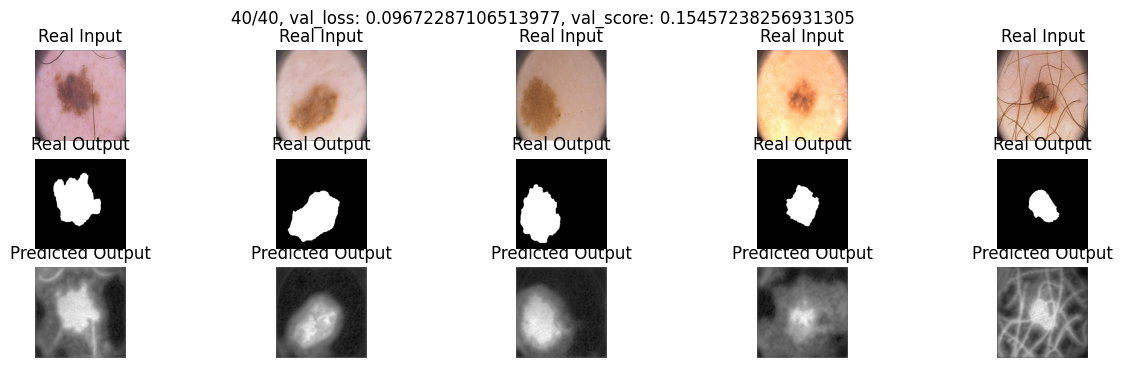

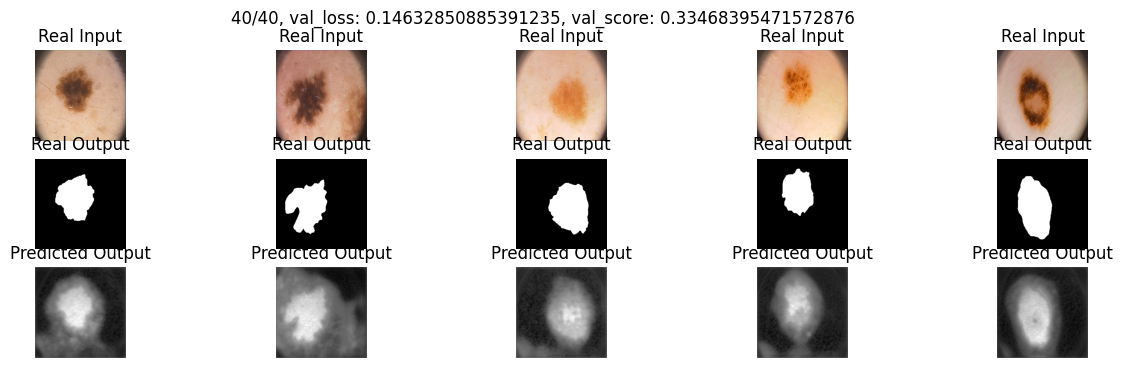

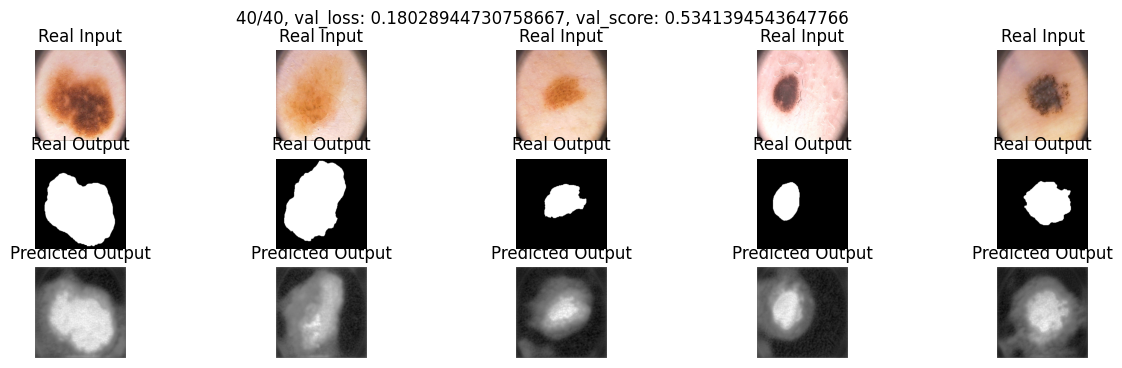

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


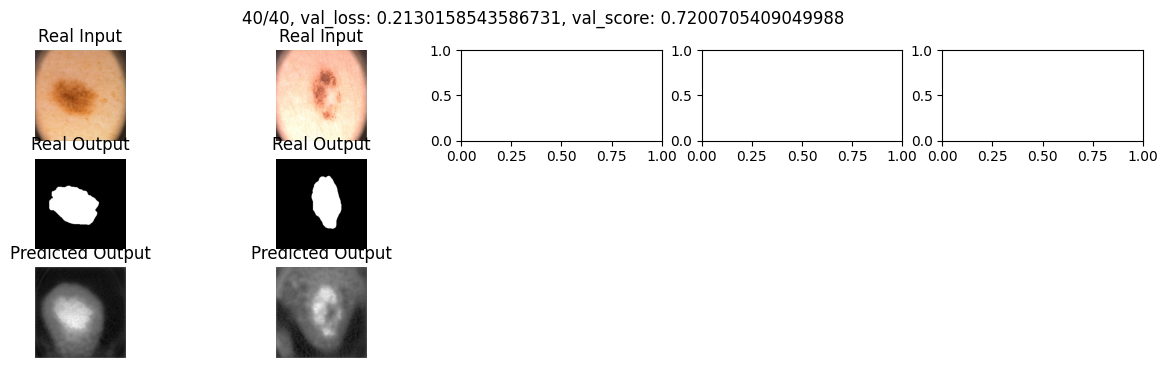

In [ ]:
del_gpu()
CFG.loss = lambda: 'bce_loss'

model = SegNet().to(CFG.device())
best_model, segnet = train(model, num_stab_bce_loss, data_train, data_val)

In [ ]:
print('Score with BCE:')
valtestscore(model)

Score with BCE:
val: 0.6725
test: 0.6914


## Extra loss functions

### Dice loss

Dice loss is pretty popular for image segmentation when dealing with imbalanced datasets. It's derived from f1-score (or Dice coefficient) which in similar tasks quantifies similarity between sets:

$Coeff_{Dice} = \frac{2\times \text{ Intersection}}{\text{Union } \times { Intersection}}  = \frac {2|\text {X } \cap { \text { Y}|}} {|X|+|Y|}$

As it has been stated above  - **intersection** - is a number of matching pixels in two masks and **union** is a total number of pxls in both masks.

After we find Dice coefficient we calculate loss $$Loss_{dice} = 1 - Coeff_{Dice}$$

#### Implement Dice loss

In [ ]:
def dice_loss(predicted, target, eps=1):
  predicted = torch.sigmoid(predicted).to(CFG.device())
  target = target.to(CFG.device())

  intersection = torch.sum(predicted * target) + eps
  union = torch.sum(predicted) + torch.sum(target) + eps
  dice_coefficient = (2. * intersection) / (union + intersection)
  #dice_coefficient = torch.clamp(dice_coefficient, 0.0, 1.0)
  dice_loss = 1 - dice_coefficient.mean()
  return dice_loss

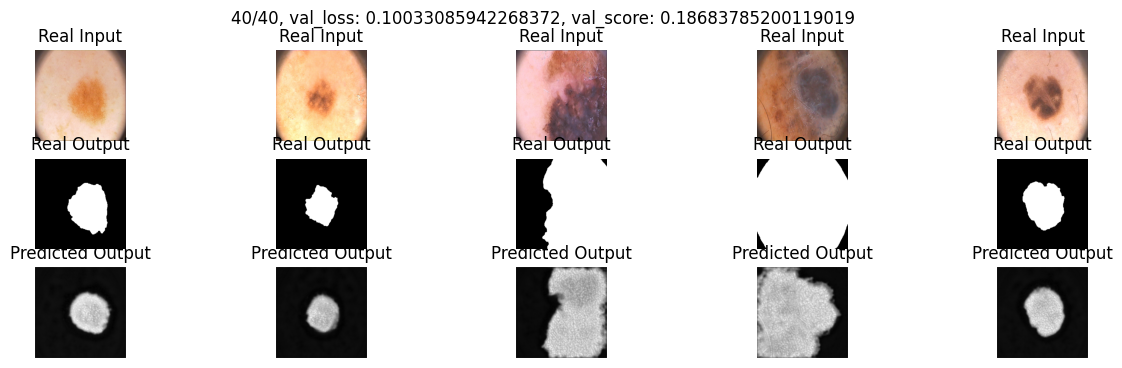

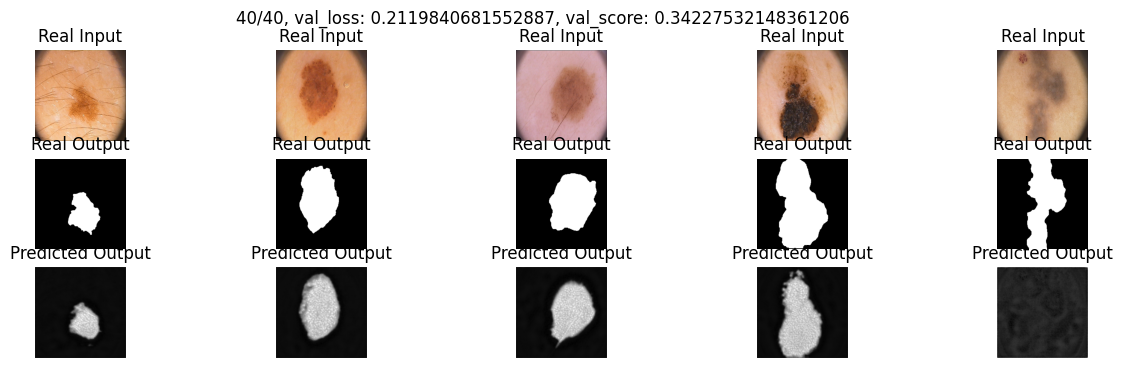

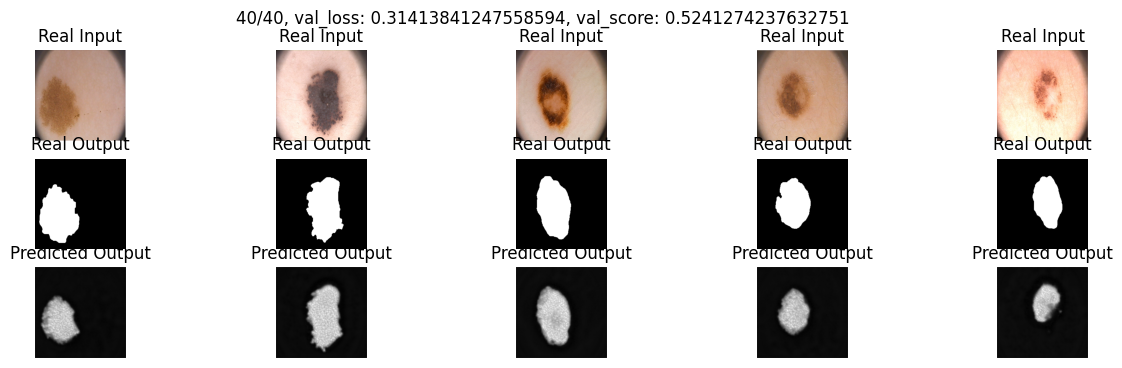

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


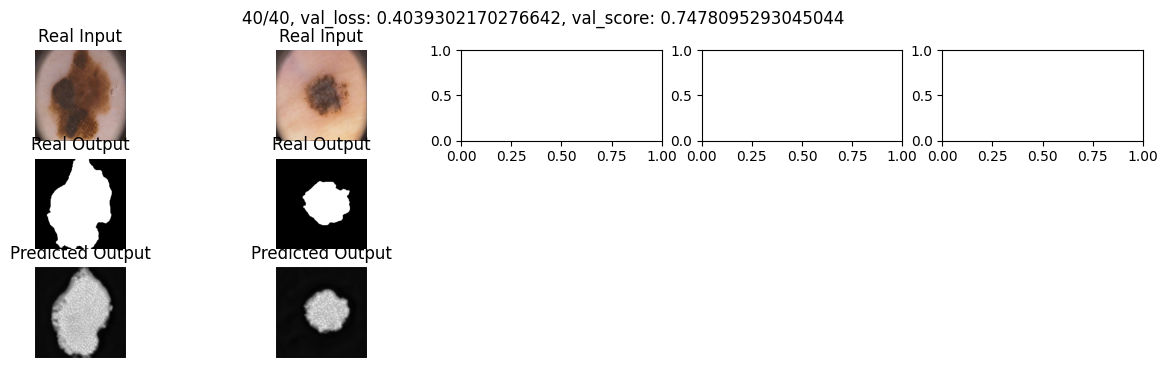

In [ ]:
CFG.loss = lambda: 'dice'
del_gpu()

model = SegNet().to(CFG.device())
best_model, segnet = train(model, dice_loss, data_train, data_val)

In [ ]:
print('Score with Dice:')
sn = SegNet()
sn.load_state_dict(best_model)
valtestscore(sn.to(CFG.device()))

Score with Dice:
val: 0.7301
test: 0.6763


### Focal loss

**Focal loss** is another implementation of BCE loss, created to fight imbalance in binary classification by giving more importance to the hard-to-classify targets, if we compare it to real-life example - it's like a teacher that **focuses on difficult questions** more during the study process.

As **Dice** loss does, it also uses **sigmoid** to make values represent probabilities and  and **epsilon** value to fight numerical instability and prevent division by zero.

But **Focal** loss also **introduces** additional parameter **gamma** - $\gamma$ which adjusts the loss func behaviour (*when* $\gamma=0$ *it's just a usual BCE loss since* $a^0 = 1$) but when it's not - it **gives additional value to hard-to-classify targets**, it weights each pixel by the probability it belongs to one or another class. Thus by doing
$$\left(1-\sigma(\hat y_i)\right)^\gamma$$ we **down-weight well-classified** targets (*for example if only one class dominates most of the examples especially when negative examples (0) overwhelm positive example (1)*).

The following term contributes to the *positive* examples. $log()$ ensures that incorrect values get penalized:

$$y_i\log\sigma(\hat y_i)$$

The part below contributes to the *negative* examples. $log()$, as you guessed it, also penalized incorrect results:

$$(1-y_i)\log(1-\sigma(\hat y_i))$$

Complete equation looks like the one below:

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

or

$$\mathcal L_{focal}(p_t)=-\alpha \cdot (1-p_t)^\gamma \cdot log(p_t)$$

where $\alpha$ is a balancing value around 1, in such a way that less than 1 it give more weight to negative class, if it is more than 1 it gives more weight to positive class.


This way focal loss concentrates more on the example which are difficult to classify, which in theory improves the performance\quality of the model given imbalanced dataset.

In [ ]:
def focal_loss(y_hat, y, gamma=2, eps = 1e-10): #no bce
  y_probs = torch.sigmoid(y_hat)              # get probabilities
  y_probs = torch.clamp(y_probs, eps, 1-eps)  # avoid num instabilities
  down_w = (1 - y_probs).pow(gamma)           # modulating factor as downweight term
  pos_term = y * torch.log(y_probs)           # positive term
  neg_term = (1 - y) * torch.log(1-y_probs)   # negative term
  loss = -((down_w * pos_term) + neg_term)    # loss
  return loss.mean()

#### Alternative focal loss

Alternativelly we could use effective probabilities and BCE with logits.

So BCE with logits:
$$\mathcal L_{BCE}(y, \hat y) = max(\hat y , 0) - \hat y \cdot y + log(1+exp(- |\hat y|)) $$

Effective probabilities using sigmoid:

$$p_{t} = \sigma(\hat y_i) \cdot y + (1-\sigma(\hat y_i)) \cdot (1-y)$$

focal loss:

$$\mathcal L_{BCE} \cdot (1 - p_t)^{\gamma}$$

and then take mean through dimensions

so altogether it is:

$$\mathcal L_{focal} = (max(\hat y , 0) - \hat y \cdot y + log(\sigma(\hat y))) \cdot (1-(\sigma(\hat y_i) \cdot y + (1 - \sigma(\hat y_i)) \cdot (1 - y)))^{\gamma} $$

or in other words:


$$\mathcal L_{focal} = \mathcal L_{BCE} \cdot (1-p_t)^{\gamma} $$

In [ ]:
def focal_loss_2(y_hat, y, gamma = 2):
  y_probs = torch.sigmoid(y_hat)      # get probabilities
  #bce with logits
  bce = torch.maximum(y_hat, torch.zeros_like(y_hat)) - y_hat*y + torch.log(1+torch.exp(-torch.abs(y_hat)))

  p_t = y_probs * y + (1 - y_probs) * (1 - y)
  loss = bce * ((1 - p_t) ** gamma) # focal loss
  loss = loss.mean((1, 2, 3)).mean()
  return loss

In [ ]:
def focal_loss_3(y_hat, y, gamma=2, eps=CFG.eps):
  # with clamp, epsilon, and bce
  y_probs = torch.sigmoid(y_hat)
  y_probs = torch.clamp(y_probs, eps, 1 - eps)

  ce_loss = F.binary_cross_entropy_with_logits(y_hat, y, reduction='mean')

  down_w = (1 - y_probs).pow(gamma)
  pos_term = down_w * y * ce_loss
  neg_term = (1 - y) * ce_loss

  loss = pos_term + neg_term

  return loss.mean()

#### example

In [ ]:
logits = torch.randn(10, 1)  # Example logits
targets = torch.randint(0, 2, (10, 1)).float()  # Example binary targets (0 or 1)
loss = focal_loss_3(logits, targets)
print("Focal Loss:", loss.item())

Focal Loss: 0.2644498348236084


#### check on model

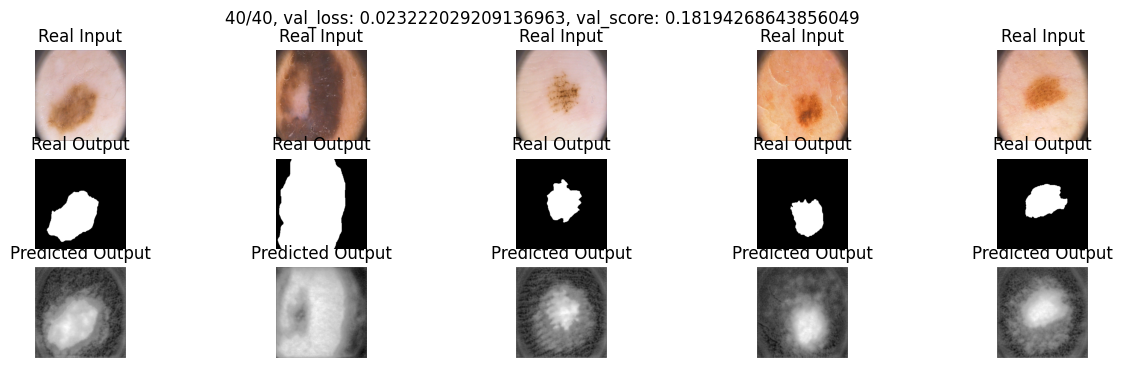

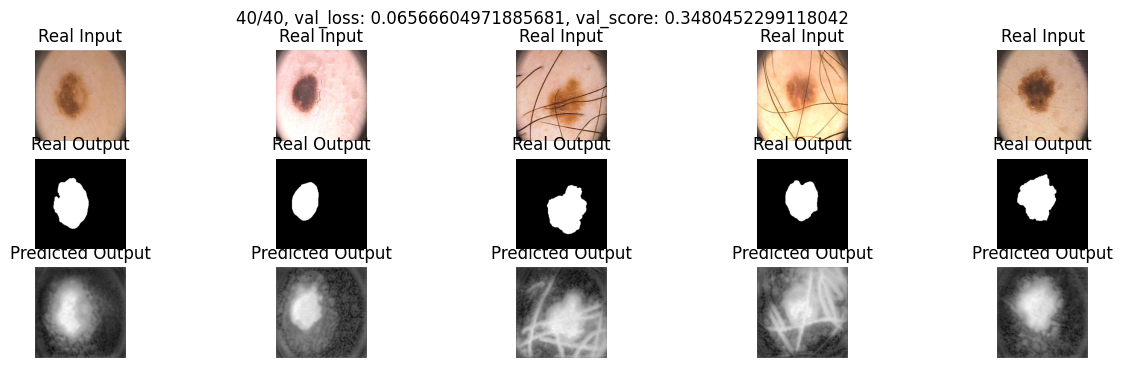

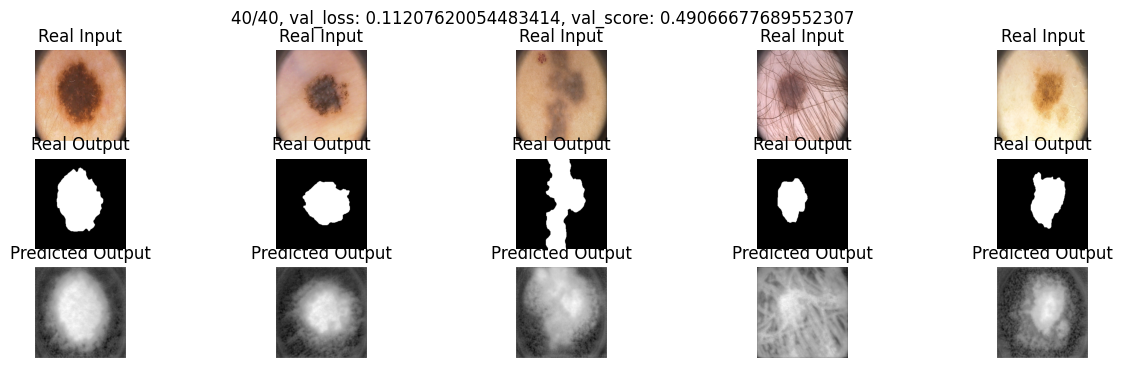

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


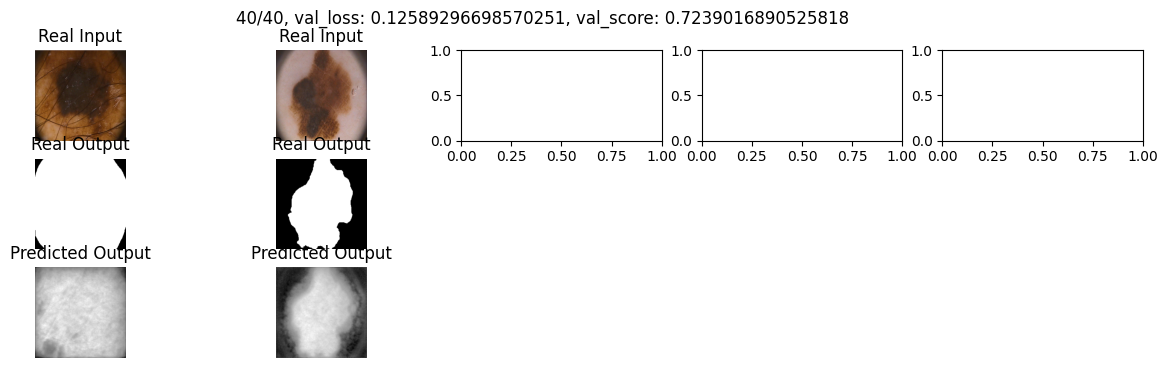

val: 0.6468
test: 0.6848
local variable 'model' referenced before assignment


In [ ]:
del_gpu()
CFG.loss = lambda: 'focal_1'

model = SegNet().to(CFG.device())
best_model, segnet = train(model, focal_loss, data_train, data_val)
valtestscore(model)

In [ ]:
print('Score with focal_loss_1:')
valtestscore(model)


Score with focal_loss_1:
val: 0.7035
test: 0.6848


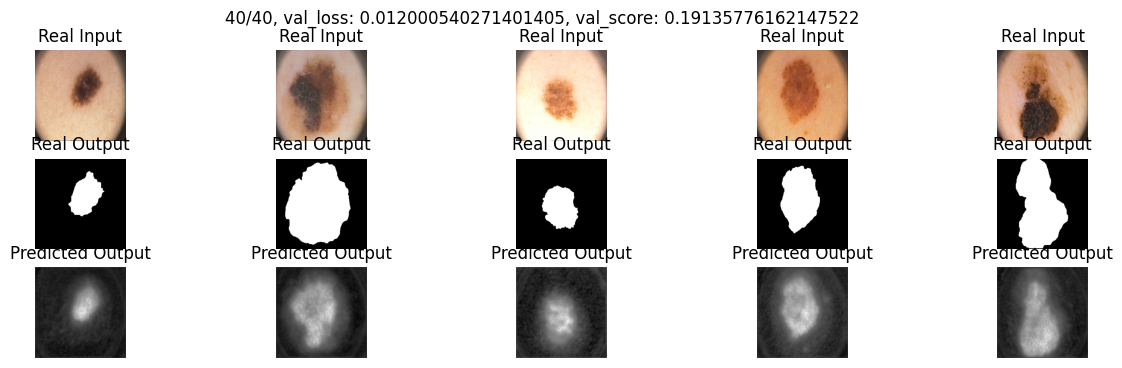

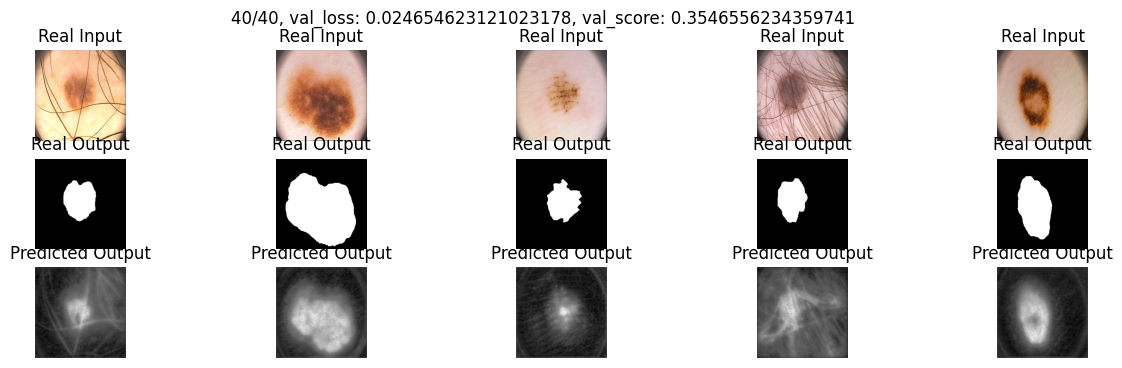

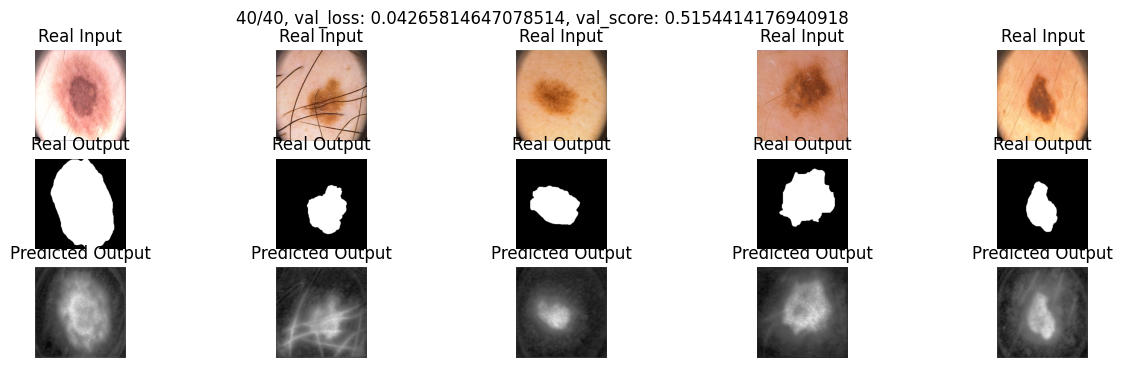

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


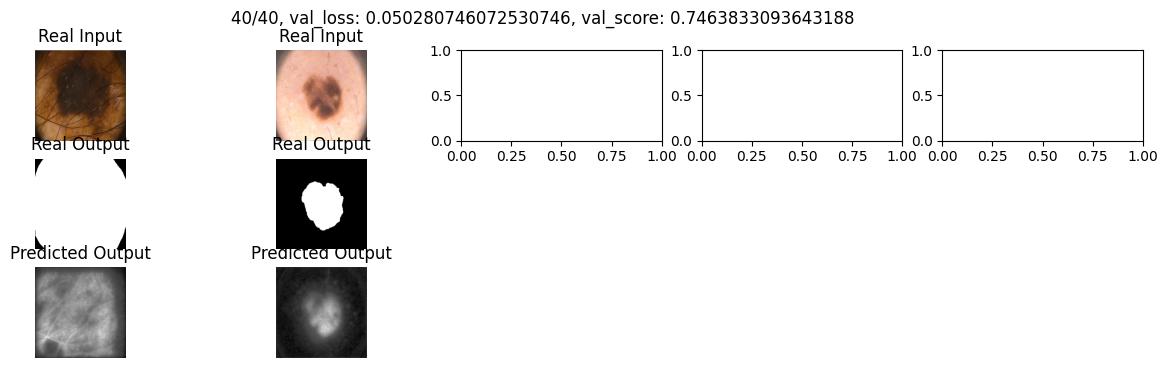

In [ ]:
del_gpu()
CFG.loss = lambda: 'focal_2'

model = SegNet().to(CFG.device())
best_model, segnet = train(model, focal_loss_2, data_train, data_val)

In [ ]:
print('Score with focal_loss_2:')
print(valtestscore(model))

Score with focal_loss_2:
val: 0.7296
test: 0.7341
None


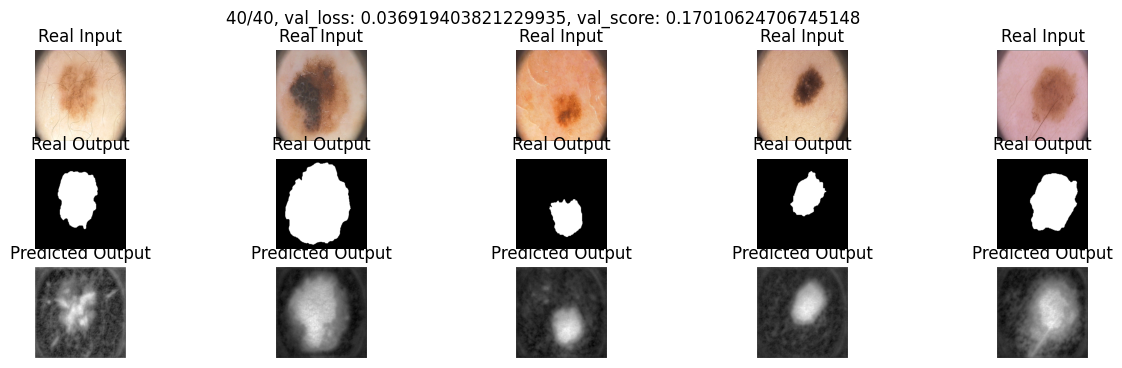

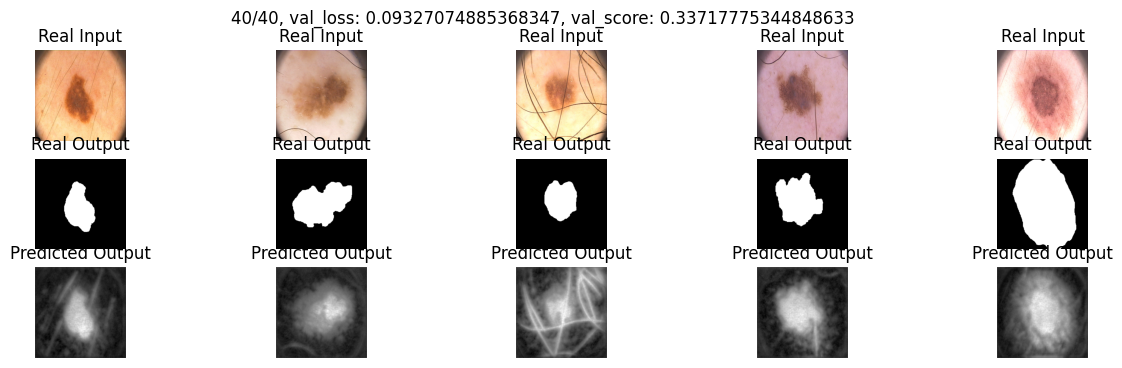

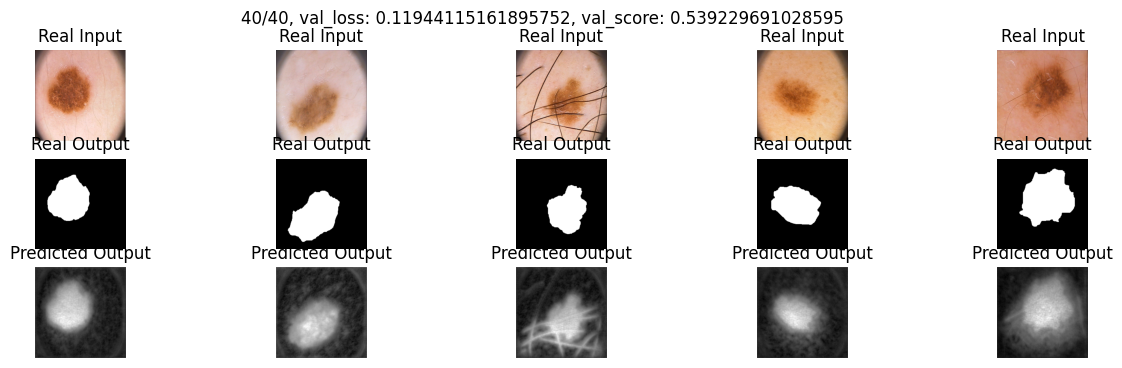

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


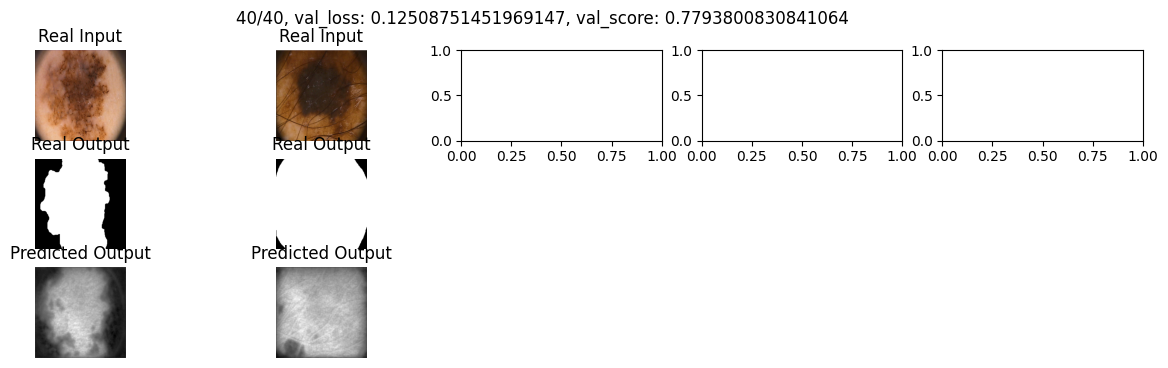

In [ ]:
del_gpu()
CFG.loss = lambda: 'focal_3'

model = SegNet().to(CFG.device())
best_model, segnet = train(model, focal_loss_3, data_train, data_val)

In [ ]:
print('Score with focal_loss_3:')
print(valtestscore(model))

Score with focal_loss_3:
val: 0.7772
test: 0.7473
None


Some statistics over runs of SegNet and BCE, DIce and focal(1, 2, 3) losses. The link to check: [W&B SegNet report](https://wandb.ai/dimildizio/Semantic_segmentation_dermoscopic/reports/SegNet_report--Vmlldzo2MDE1OTAy)

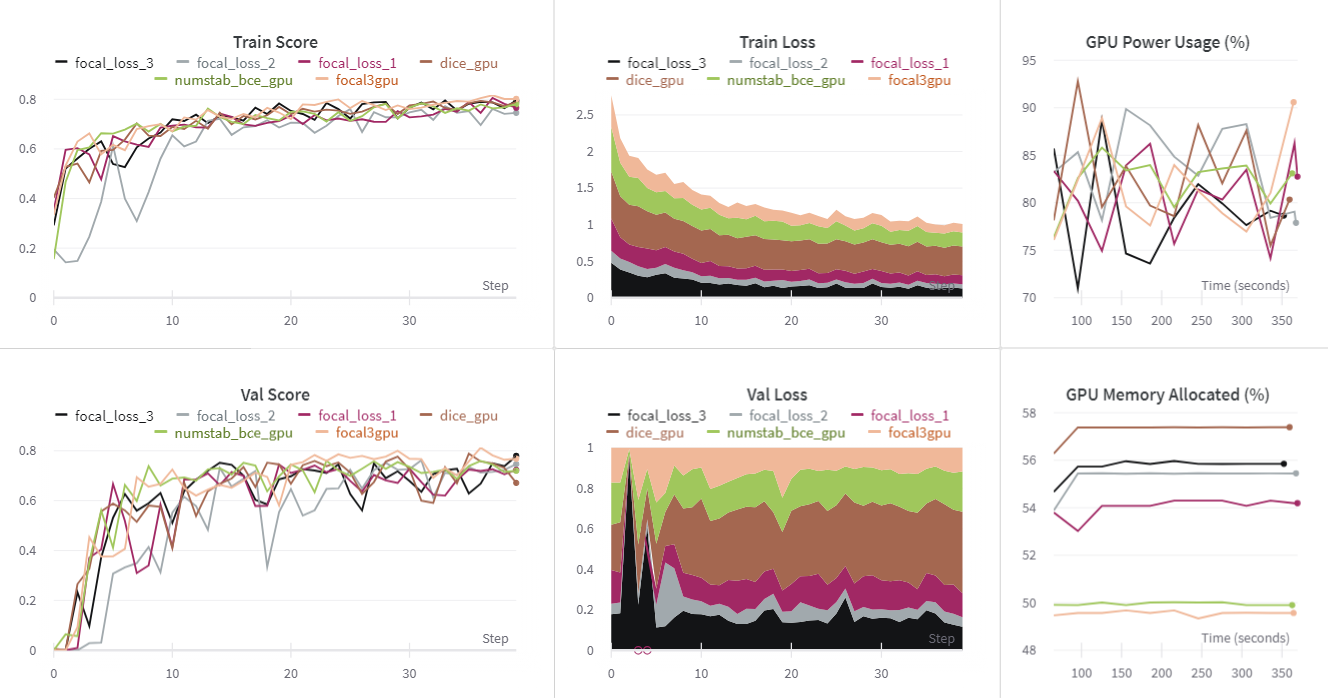

## More loss functions

There are many loss functions for segmentation task. We'll review a few. Here's a map (kudos [@JunMa11](https://github.com/JunMa11/SegLossOdyssey))

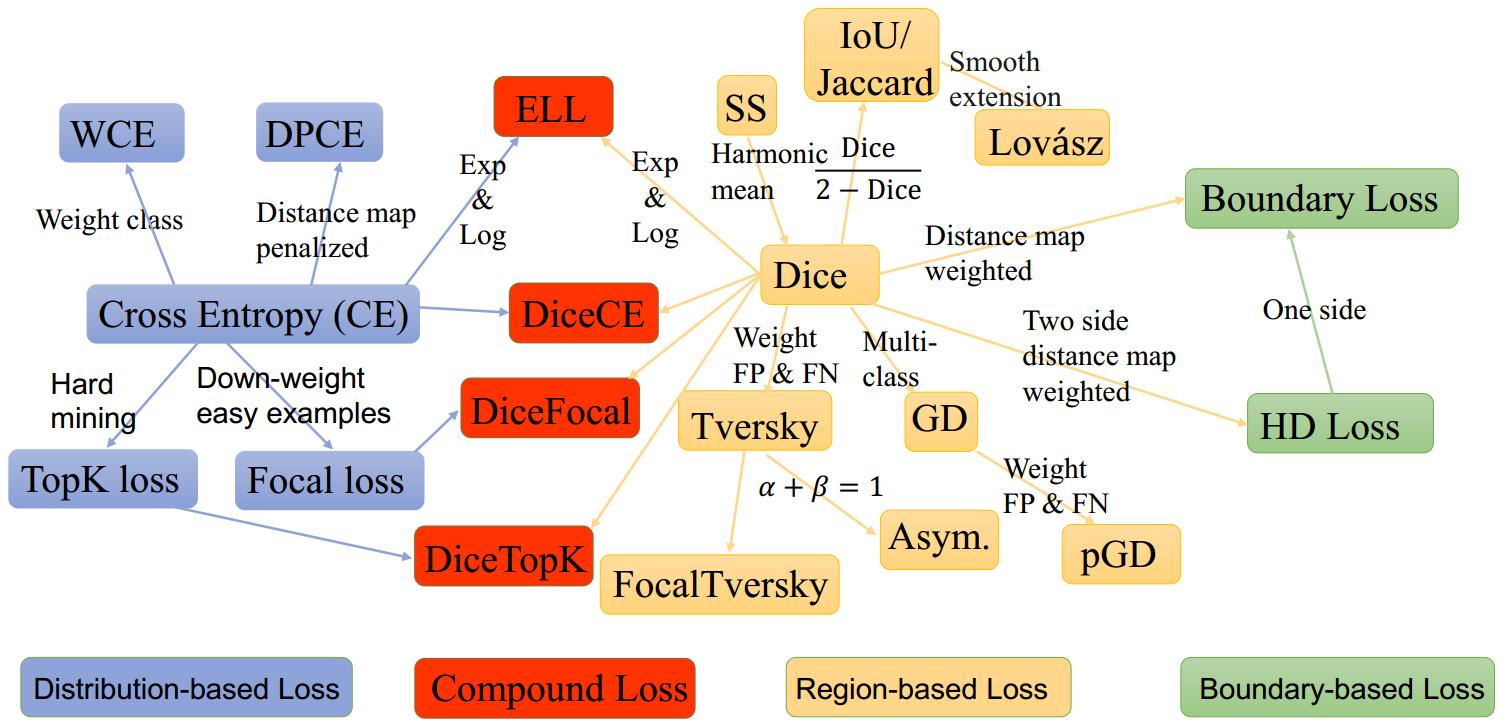

### Boundary loss

Boundary loss as you can guess it is created to find *boundaries* **around** the object. Somehow similar to convex-hull algorithm, it computes the distance between pixels for true and predicted boundaries, so, naturally it doesn't fit our task at all. But for the sheer love for science we are still going to spend our precious colab gpu resources to try and train the model using this kind of loss!

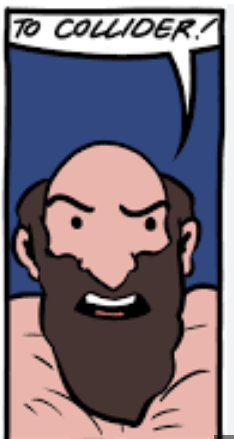

In [ ]:
def boundary_loss(y_pred, y_true):
  y_pred = torch.sigmoid(y_pred)
  boundary_true = F.max_pool2d(1 - y_true, kernel_size=3, stride=1, padding=1)
  boundary_pred = F.max_pool2d(1 - y_pred, kernel_size=3, stride=1, padding=1)

  dist = torch.norm(boundary_true - boundary_pred, p=2, dim=(1, 2, 3))
  loss = torch.mean(1 - torch.exp(-dist)+CFG.eps)
  return loss

def boundary_loss_2(y_pred, y_true, delta=1, boundary_weight=1.5):
    y_pred = torch.sigmoid(y_pred)

    dist_true = distance_map(y_true)
    dist_pred = distance_map(y_pred)

    boundary_term = torch.exp(1 - torch.abs(dist_true - dist_pred) / delta)
    seg_loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
    loss = seg_loss + boundary_weight * (1 - boundary_term).mean()
    return loss


def distance_map(mask):
    batch_size, _, height, width = mask.size()
    distance_maps = torch.zeros_like(mask)
    for batch in range(batch_size):
        for i in range(height):
            for j in range(width):
                if mask[batch, 0, i, j] > 0.5:  # Pixel belongs to the object
                    distance_maps[batch, 0, i, j] = min_distance_to_background(mask[batch, 0], i, j)
    return distance_maps


def min_distance_to_background(mask, i, j):
    height, width = mask.size()
    distances = []
    for x in range(height):
        for y in range(width):
            if mask[x, y] < 0.5:  # Pixel belongs to the background
                distances.append((x - i)**2 + (y - j)**2)
    return min(distances)


In [ ]:
del model
del_gpu()
CFG.epochs = 40
CFG.lr = 3e-6
CFG.loss = lambda: 'boundary_loss'

model = SegNet().to(CFG.device())
best_model, segnet = train(model, boundary_loss, data_train, data_val)

In [ ]:
print('Score with boundary loss:')
valtestscore(model)


Score with boundary loss:
val: 0.2266
test: 0.2515


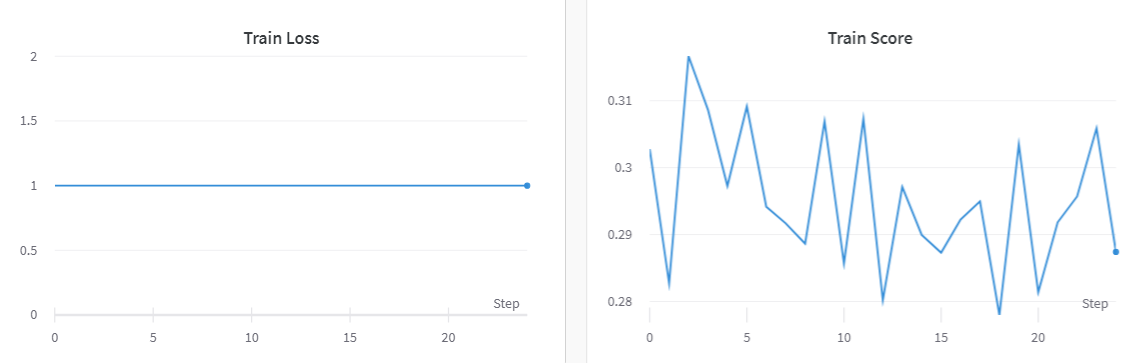

Boundary loss definitelly behaves as we've predicted - it doesn't work since (you've guessed it) it is good only for boundaries and in a task where we need segmentation for the whole object (not just the boundary) the loss is 1 and it won't work at all - as you can see from the train graph - it just doesn't learn due to how it works in it's concept and the label. There is also a way to create a distance map for every preditted and every true label then introduce a boundary weight and take the mean the result:  $$\mathcal L_{boundary} = BCE + \text{boundary_weight}\cdot (1-\exp(1-|(\hat{y}_{dist} - y_{dist})|))$$

But after all they are so expensive operations that it results in overflow or close to it and takes so much time it's impossible even on gpu to calculate even a batch.

### Asymetric loss

Asym loss is designed to battle class imbalance where one class is more important than the other. In our task it allows us to assign weights to False Positive and False Negative results, for example if correctly classifying one class (say, skind damage from skin cancer) is crucial.

If we compare it to other loss function, BCE - treats both classes equally, Dice loss ephasizes overlaps between two masks thus also doesn't really address importance of one class over another and class imbalance, focal loss focuses on hard-to-classify examples.

Asym loss introduces different weights for False Negative and False Positive results allowing us to customize loss function based on our task. We will perform a series of experiments to see which is more important (spoiler - FP).

$$\text{AsymmetricLoss}(y_{pred}, y, \beta_{fp}, \beta_{fn}) = 1 - \frac{{\text{precision}} \cdot \text{recall}}{\text{precision} + \text{recall} + ɛ}$$

where

$$\text{precision} = \frac{{\text{TP}}}{\beta_{fp} \cdot FP + TP +ɛ}$$

$$\text{recall} = \frac{{\text{TP}}}{\beta_{fn} \cdot FN + TP +ɛ}$$



In [ ]:
def asymmetric_loss(y_pred, y_true, beta_fp=1.2, beta_fn=0.8):
    #lets say that false positives are a bit more important (1.1:0.9)
    #and try vice versa (0.8:1.2) for the next run
    y_pred = torch.sigmoid(y_pred)
    tp = torch.sum(y_true * y_pred)
    fp = torch.sum((1 - y_true) * y_pred)
    fn = torch.sum(y_true * (1 - y_pred))

    precision = tp / (beta_fp * fp +tp + CFG.eps)
    recall = tp / (beta_fn * fn + tp + CFG.eps)

    loss = 1 - (precision * recall) / (precision + recall + CFG.eps)
    return loss

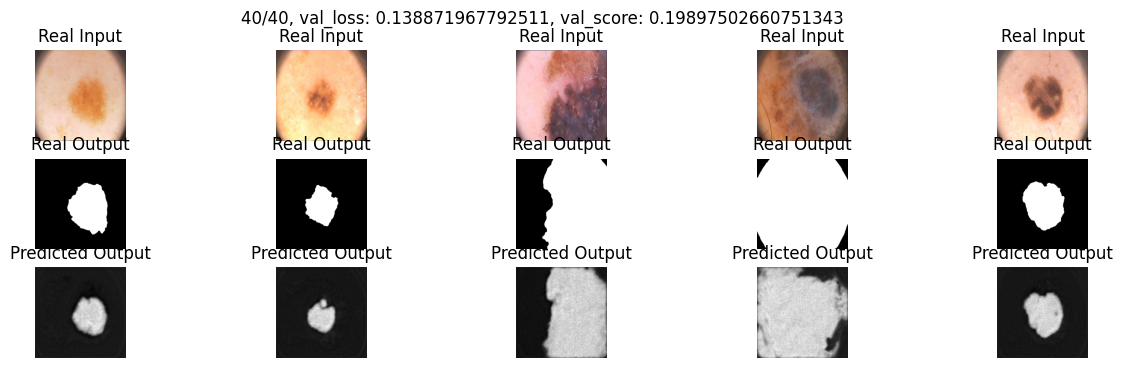

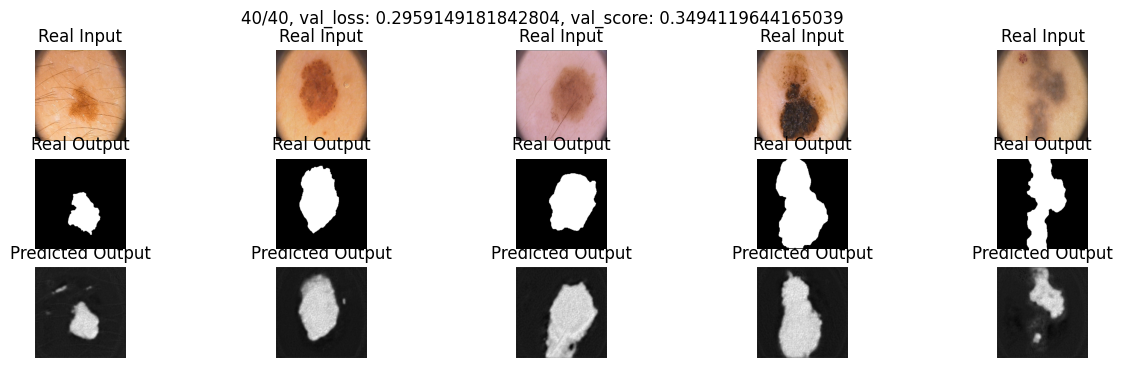

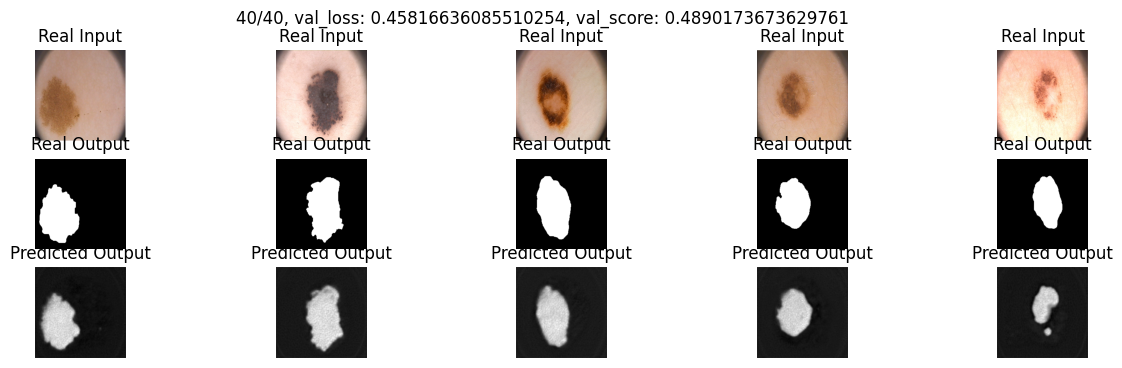

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


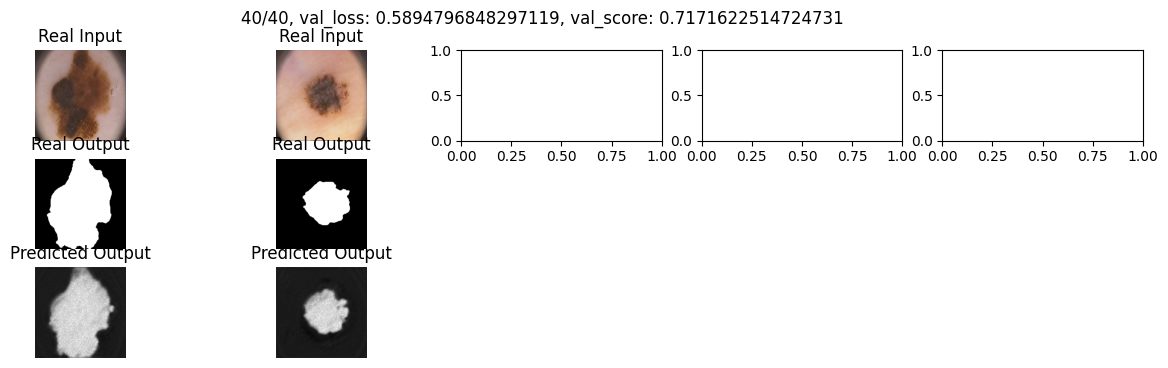

In [ ]:
#fp is 1.1 fn is 0.9
CFG.loss = lambda: 'asymmetric_loss'
model = SegNet().to(CFG.device())
best_model, segnet = train(model, asymmetric_loss, data_train, data_val)

In [ ]:
print('Score with asymmetric loss:')
valtestscore(model)




Score with asymmetric loss:
val: 0.7475
test: 0.7362


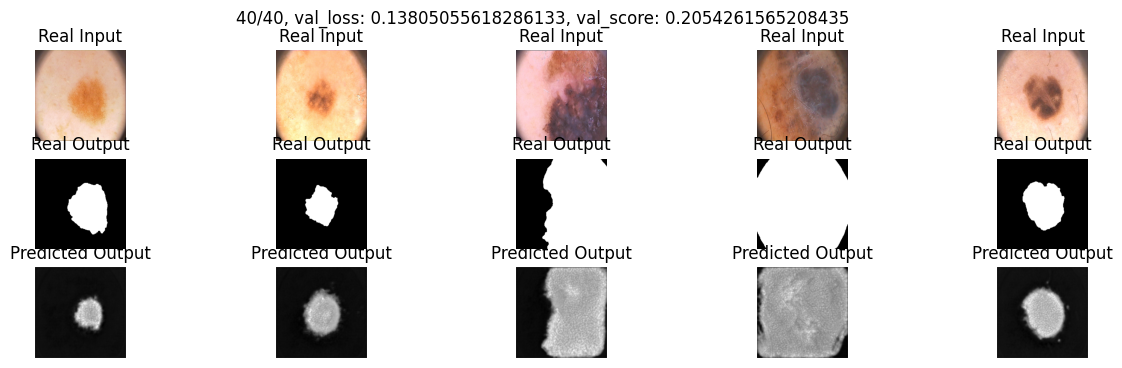

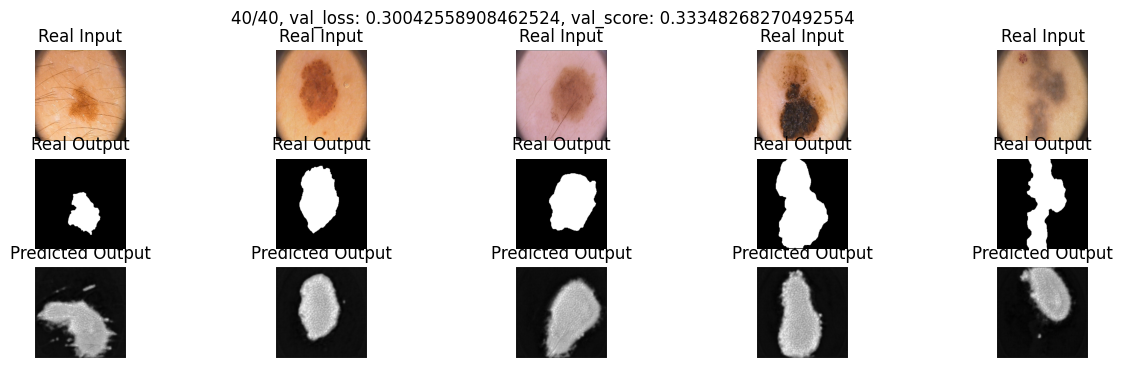

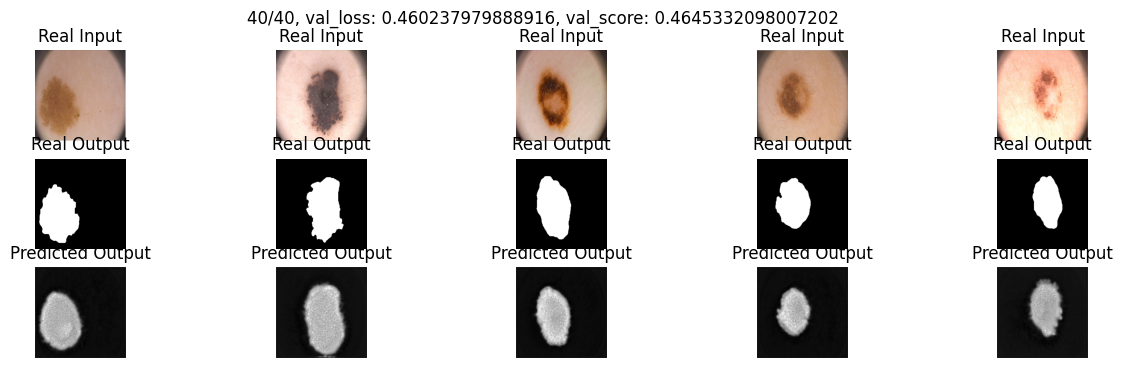

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


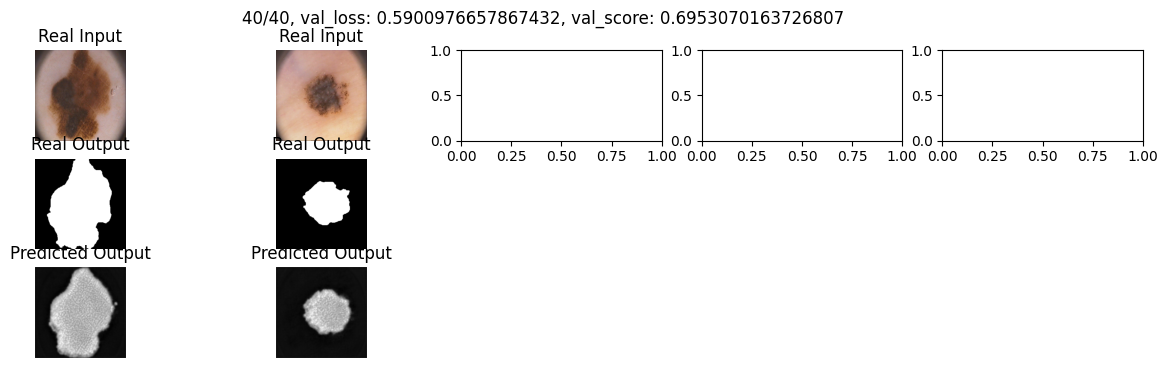

In [ ]:
# run for fp importance is 0.8 and fn is 1.2
del_gpu()
CFG.epochs = 40
CFG.loss = lambda: 'asymmetric_loss'
model = SegNet().to(CFG.device())
best_model, segnet = train(model, asymmetric_loss, data_train, data_val)

In [ ]:
print('Score with asymmetric loss (fp:0.8 fn:1.2):')
valtestscore(model)

Score with asymmetric loss (fp:0.8 fn:1.2):
val: 0.6754
test: 0.6747


As we can see, with higher importance for FN it has appeared that incorrectly predicting a positive class when it is actually negative (FP) is more important for the model thus it is advised to prioritise **FP over FN**.

### Top-K loss and DiceTop-K loss

#### Top-K

Top-K is used to select the K elements with the highest values from a set. In segmentation task, if we have probability scores for each pixel, we can use Top-K to select the K pixels with the highest probabilities.

#### Dice Top-K

It is pretty similar with Top-K with the one difference that for Ys we take top-k probablity classes

$\mathcal L_{\text{Dice top-K}} = \frac {2|\text {X } \cap { \text { Y}}_{top-K}|} {|X|+|Y_{\text{top-K}}|}$

While standard Dice consideres all positive regions, Dice top-K is designed to predict multiple classes or top-k predicted regions. So we don't really need top-k since just got classes 0 and 1. Overall it will not provide any benefit over usual Dice.

### Tversky loss

Well, it is stated in task that for Tversky you get less points due to it's similary to Dice, researching into all other losses (not just Tversky) grats us a privilege to study Tversky as well, since I'm pretty sure everyone would skip it due to the reasons above.

Tversky - is, as stated before, a modification of **Dice loss**, designed to hadle imbalanced data in binary classification for segmentation.

Idea is pretty simple compared to other loss funcs.

$$\mathcal L_{Tversky} = \frac{TP}{TP + α \cdot FN + β \cdot FP} $$

Where $α$ and $β$ are weights for False Negatives and False Positives and are called to give equal importance to FP and FN (sounds familiar to **asym loss**, right? Just simplier)

In [ ]:
def tversky_loss(y_hat, y, a=0.7, b=0.3):
  y_pred = torch.sigmoid(y_hat).to(CFG.device())
  y = y.to(CFG.device())
  intersection = torch.sum(y * y_pred)  #tp
  fn = torch.sum(y * (1-y_pred)) * a
  fp = torch.sum((1-y) * y_pred) * b
  tversky = (intersection+CFG.eps) / (intersection + fn + fp + CFG.eps)
  t_loss = 1 - tversky
  return t_loss

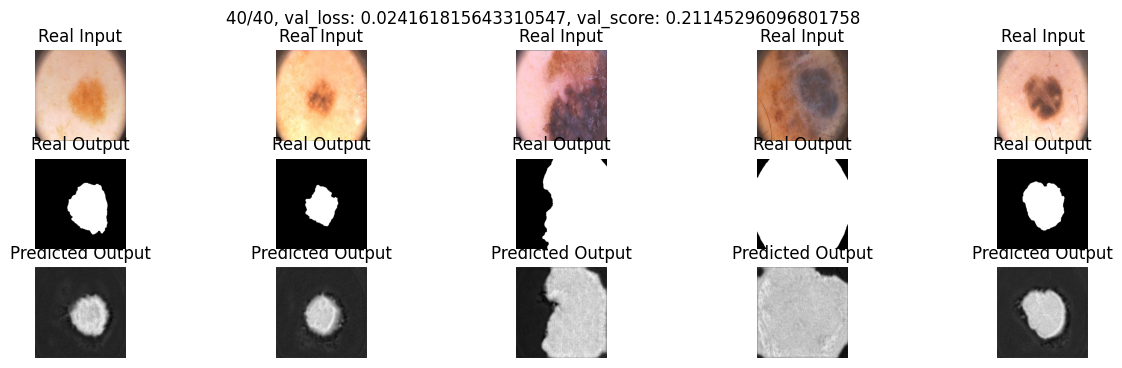

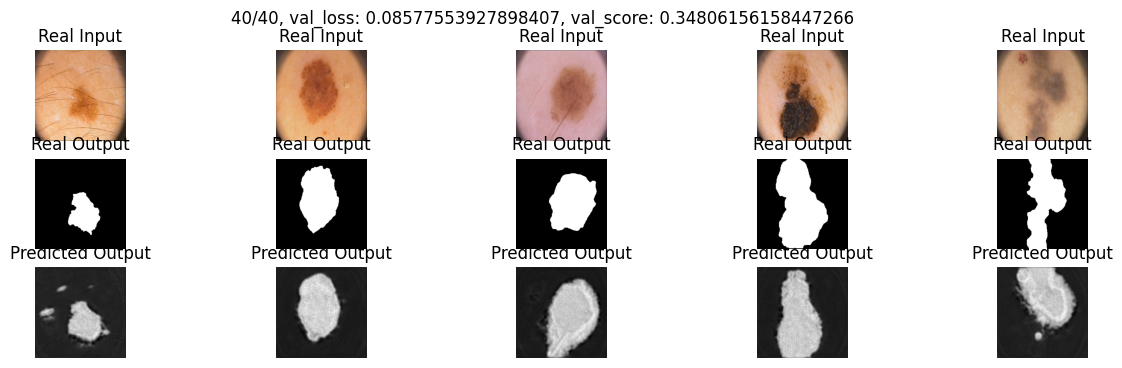

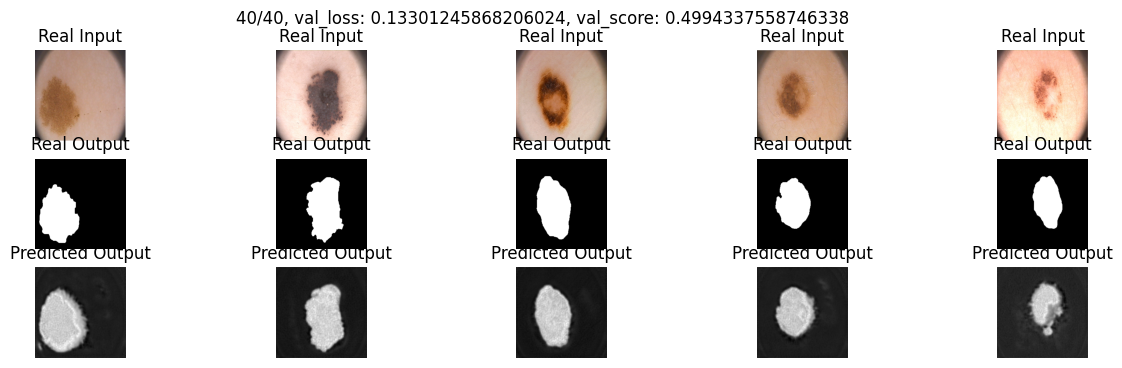

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


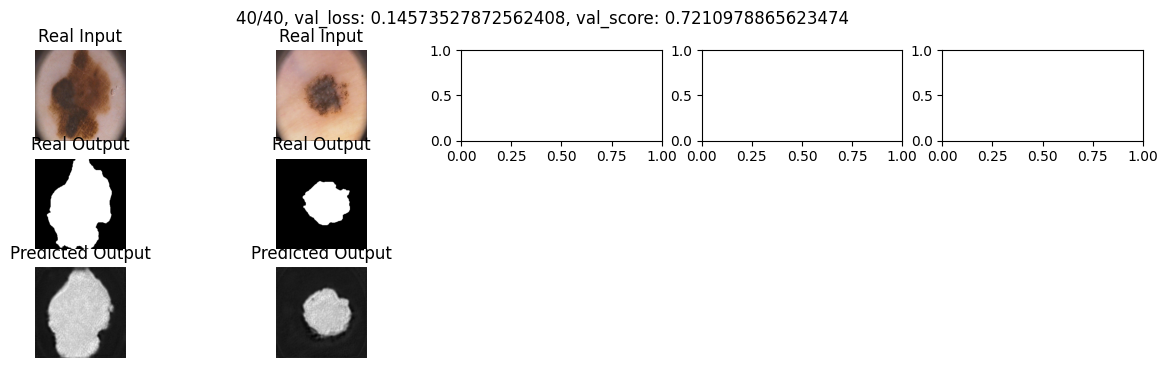

In [ ]:
try:
  del_gpu()
  del model
except Exception as e:
  print(e)

CFG.epochs = 40
CFG.loss = lambda: 'tversky_loss'
model = SegNet().to(CFG.device())
best_model, segnet = train(model, tversky_loss, data_train, data_val)

In [ ]:
print('Tversky Loss score:')
sn = SegNet()
sn.load_state_dict(best_model)
valtestscore(sn.to(CFG.device()))

Tversky Loss score:
val: 0.7188
test: 0.6778


### Lovasz loss

Lovasz loss is a kind of optimization over IoU metric in segmentation tasks. The problem with IoU is that it's not differentiable whereas Lovasz **provides** kind of a surrogate **function** that is **differentiable**. It introduces  Lovasz extension which converts non-diff function into a continuous one. It is a bit more complex than other loss function since it utilized gradient. We also do not use sigmoid here (at least for binary classification segmentation task we don't need softmax) thus calculations are performed on raw logits.



Given logits $\hat{y}$ (from $-∞$ to $+∞$) and binary Ground Truth  y (0 | 1) and a hinge max(0, 1-z) - basically it's ReLU:

$$\mathcal L_{LovaszHinge}(\hat{y}, y) = ∑\limits_{i=1}^{P}ReLU(1-sign(y_i) \cdot \hat{y}_i)$$

where *sign* return -1 for y=0 and 1 for y=1

The gradient (kudos to [Belousov Alexandr](https://github.com/Belousov-Aleksandr) for a proper code implementation of gradient for this loss) would be:

$$G_{lovasz}(y_{sorted}) = \sum\limits_{i=1}^{P}\frac{1}{i}$$

where $y_{sorted}$ is sorted Ground Truth labels

So overall Lovasz hinge loss is element-wise sum of sorted errors and corresponding gradient:

$$\mathcal L_{Lovasz}(\hat{y}, y) = ∑\limits_{i=1}^{P}ReLU(1-sign(y_i) \cdot \hat{y}_i) \cdot G_{lovasz}(y_{sorted}) $$


In [ ]:
class LovaszHingeLoss(nn.Module):

    def forward(self, logits, targets):
        lovasz_loss = lovasz_hinge(logits, targets)
        return lovasz_loss

def lovasz_hinge(logits, labels):
    """
    Binary Lovász hinge loss
    logits: [B, H, W] Variable, logits at each prediction (between -inf and +inf).
    labels: [B, H, W] Tensor, binary ground truth labels (0 or 1).
    """
    logits = logits.view(-1)
    labels = labels.view(-1)

    signs = 2. * labels.float() - 1.  # -1 for 0 labels and 1 for 1s
    errors = 1. - logits * signs

    # get sorted ground truth
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]

    grad = lovasz_grad(gt_sorted.to(CFG.device()))  # gradient is also calculated in backward()
    loss = torch.dot(F.relu(errors_sorted.to(CFG.device())), grad)
    return loss

def lovasz_grad(gt_sorted):
    """
    Compute gradient of the Lovasz hinge loss.
    gt_sorted: [P] Tensor, sorted binary ground truth labels (0 or 1).
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    iou = 1. - intersection / union
    iou[1:p] = iou[1:p] - iou[0:-1]
    return iou

Let's give Lovacz a try

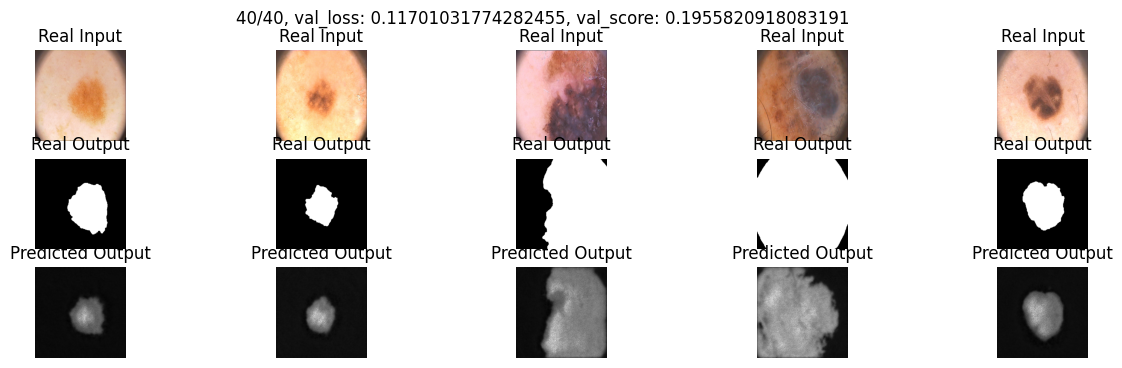

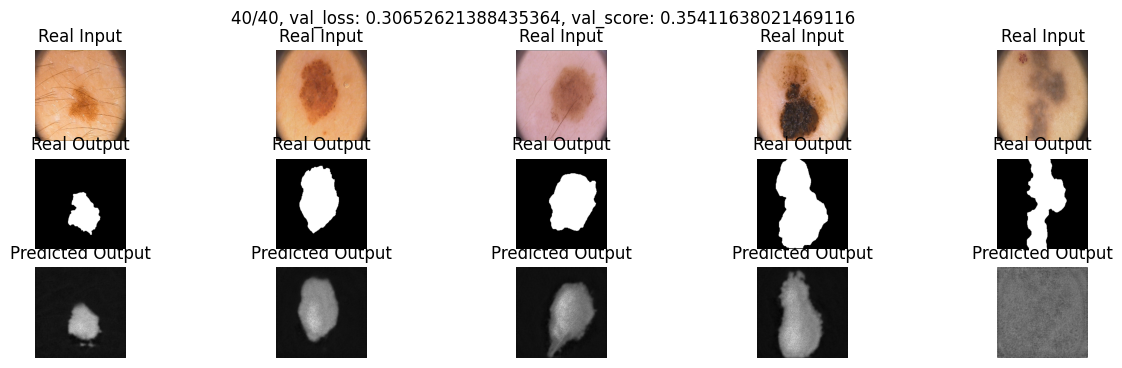

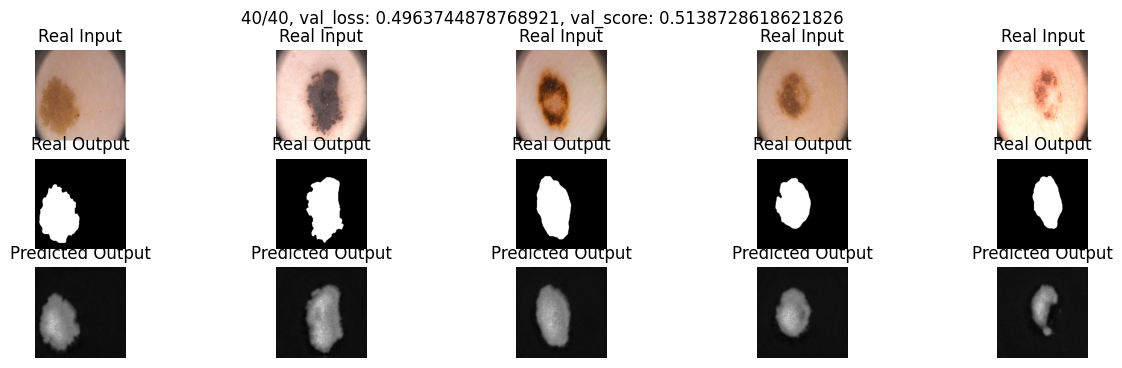

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


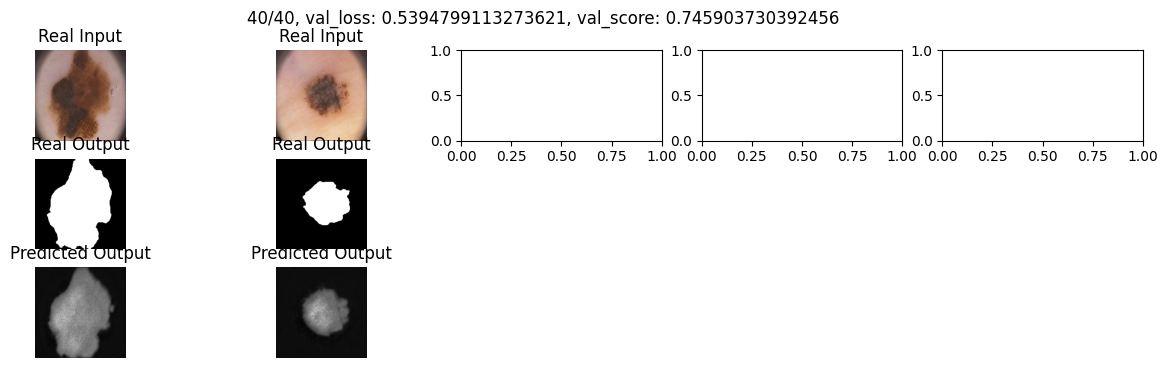

In [ ]:
try:
  del_gpu()
  del model
except Exception as e:
  print(e)

CFG.loss = lambda: 'lovasz'
model = SegNet().to(CFG.device())
lovasz = LovaszHingeLoss()
best_model, segnet = train(model, lovasz, data_train, data_val)

In [ ]:
print('Lovasz Loss score:')
sn = SegNet()
sn.load_state_dict(best_model)
valtestscore(sn.to(CFG.device()))

Lovasz Loss score:
val: 0.7520
test: 0.7552


Overall Lovacz has provided the best results among other models but the winner is focal loss. It seems that enabling a surrogate gradient to make loss function learn is a pretty decent idea.

## Plotting graphs

In [ ]:
segnet_data = {'bce': [0.6725, 0.6914], 'dice': [0.7301, 0.6763],
               'focal_1':[0.7035, 0.6848], 'focal_2':[0.7296, 0.7341],
               'focal_3':[0.7772, 0.7473], #'boundary': [0.2266, 0.2515],
               'asym_fp>fn':[0.7475, 0.7362], 'asym_fn>fp':[0.6754, 0.6747],
               'tverskoy':[0.7188, 0.6778], 'lovasz':[0.7520, 0.7552]}
segnet_df = pd.DataFrame(segnet_data, index=['val', 'test']).T
segnet_df

val    test
bce         0.6725  0.6914
dice        0.7301  0.6763
focal_1     0.7035  0.6848
focal_2     0.7296  0.7341
focal_3     0.7772  0.7473
asym_fp>fn  0.7475  0.7362
asym_fn>fp  0.6754  0.6747
tverskoy    0.7188  0.6778
lovasz      0.7520  0.7552

In [ ]:
def draw_graphs(df):
  sns.set(style="whitegrid")
  plt.figure(figsize=(16, 12))

  # Bar plot for validation set
  plt.subplot(3, 2, 1)
  sns.barplot(x=segnet_df.index, y=segnet_df['val'], palette='Blues')
  plt.title('Validation Score for Different Loss Functions')
  plt.xlabel('Loss Function')
  plt.ylabel('Score (Validation)')
  plt.xticks(rotation=45, ha='right')
  # Bar plot for test set
  plt.subplot(3, 2, 2)
  sns.barplot(x=segnet_df.index, y=segnet_df['test'], palette='Reds')
  plt.title('Test Score for Different Loss Functions')
  plt.xlabel('Loss Function')
  plt.ylabel('Score (Test)')
  plt.xticks(rotation=45, ha='right')

  # Line plot for validation set
  plt.subplot(3, 2, 3)
  sns.lineplot(x=segnet_df.index, y=segnet_df['val'], marker='o', color='b')
  plt.title('Validation Score Trend for Different Loss Functions')
  plt.xlabel('Loss Function')
  plt.ylabel('Score (Validation)')
  plt.xticks(rotation=45, ha='right')
  # Line plot for test set
  plt.subplot(3, 2, 4)
  sns.lineplot(x=segnet_df.index, y=segnet_df['test'], marker='o', color='r')
  plt.title('Test Score Trend for Different Loss Functions')
  plt.xlabel('Loss Function')
  plt.ylabel('Score (Test)')
  plt.xticks(rotation=45, ha='right')

  # Box plot for validation set
  plt.subplot(3, 2, 5)
  sns.boxplot(x=segnet_df['val'], color='b')
  plt.title('Validation Score Distribution for Different Loss Functions')
  plt.xlabel('Score (Validation)')
  # Box plot for test set
  plt.subplot(3, 2, 6)
  sns.boxplot(x=segnet_df['test'], color='r')
  plt.title('Test Score Distribution for Different Loss Functions')
  plt.xlabel('Score (Test)')
  plt.title('SegNet')

  plt.suptitle('SegNet - Comparison of Loss Functions', fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

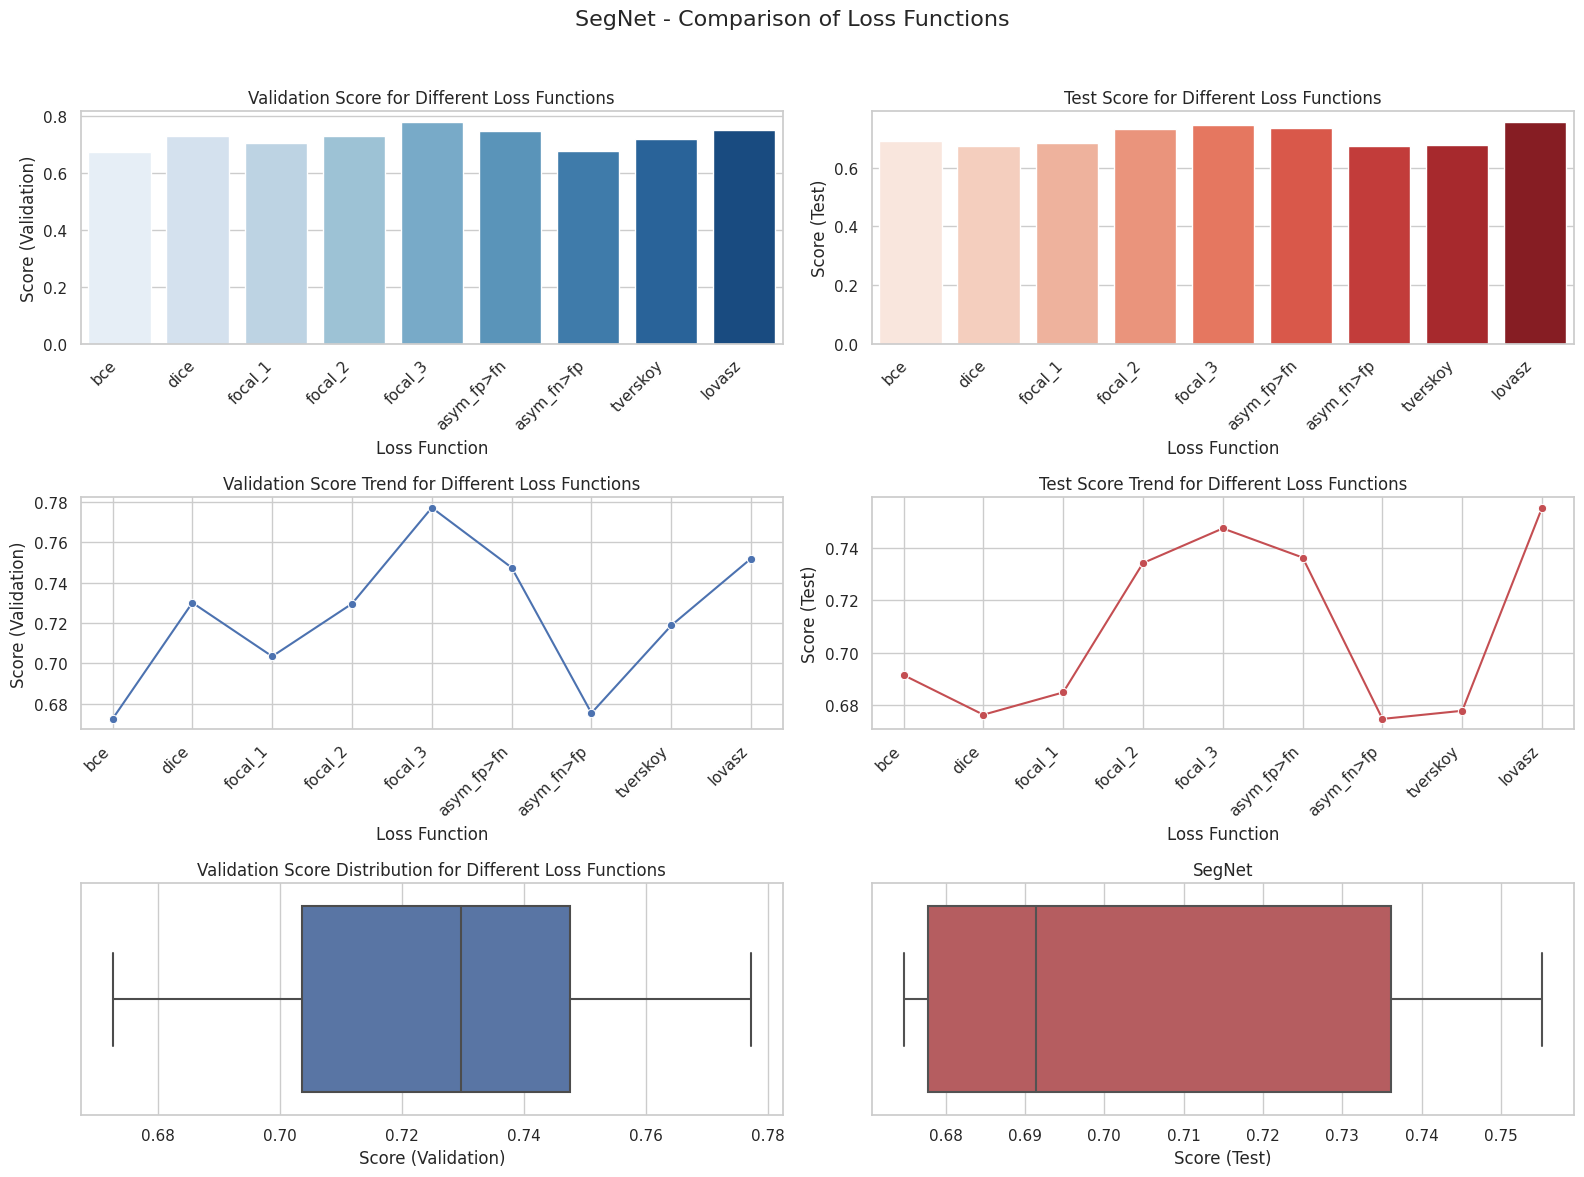

In [ ]:
draw_graphs(segnet_df)

#### One important thing to note - a lot depends on the initial Learning Rate

And it seems that 1e-4 is better than 3e-4 (and 1e-3 of course), maybe 5e-5 would provide even better results, but it's computative-expensive to check

### Some graphs for SegNet

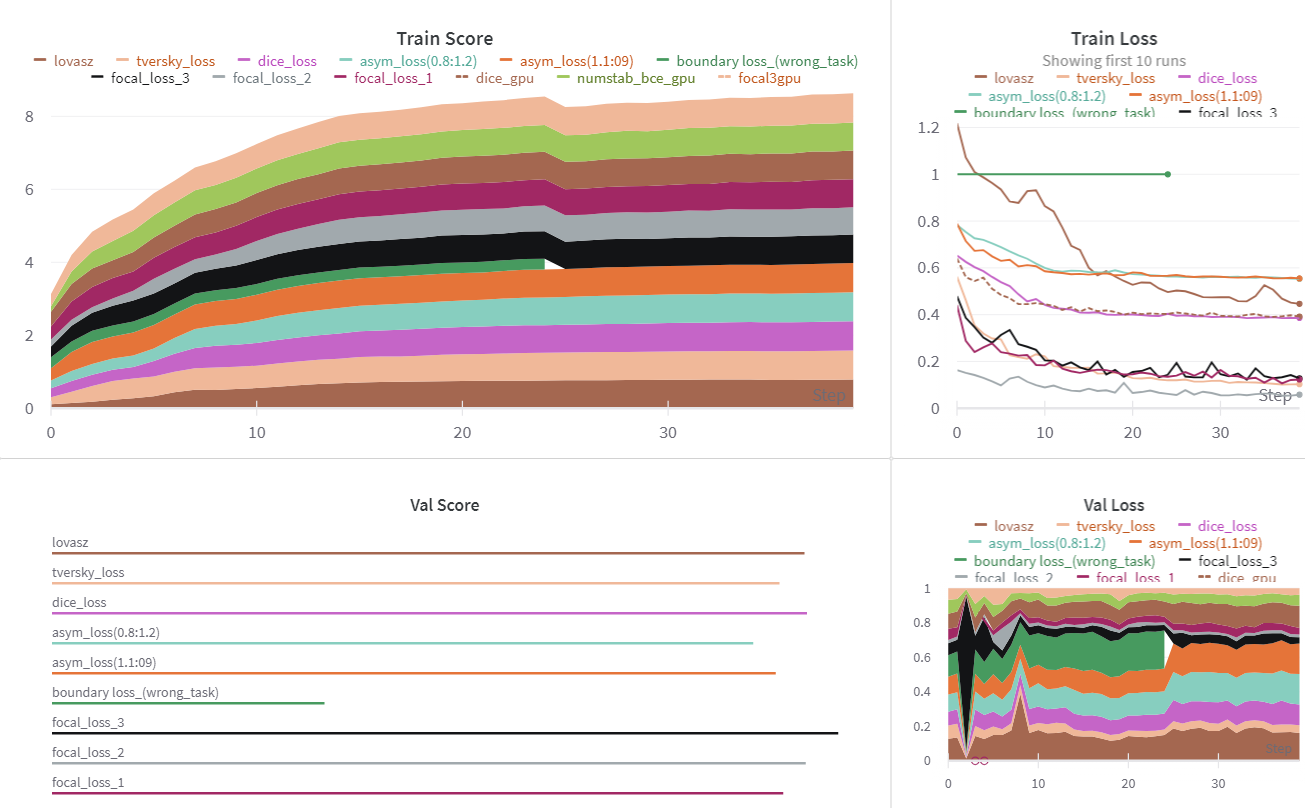

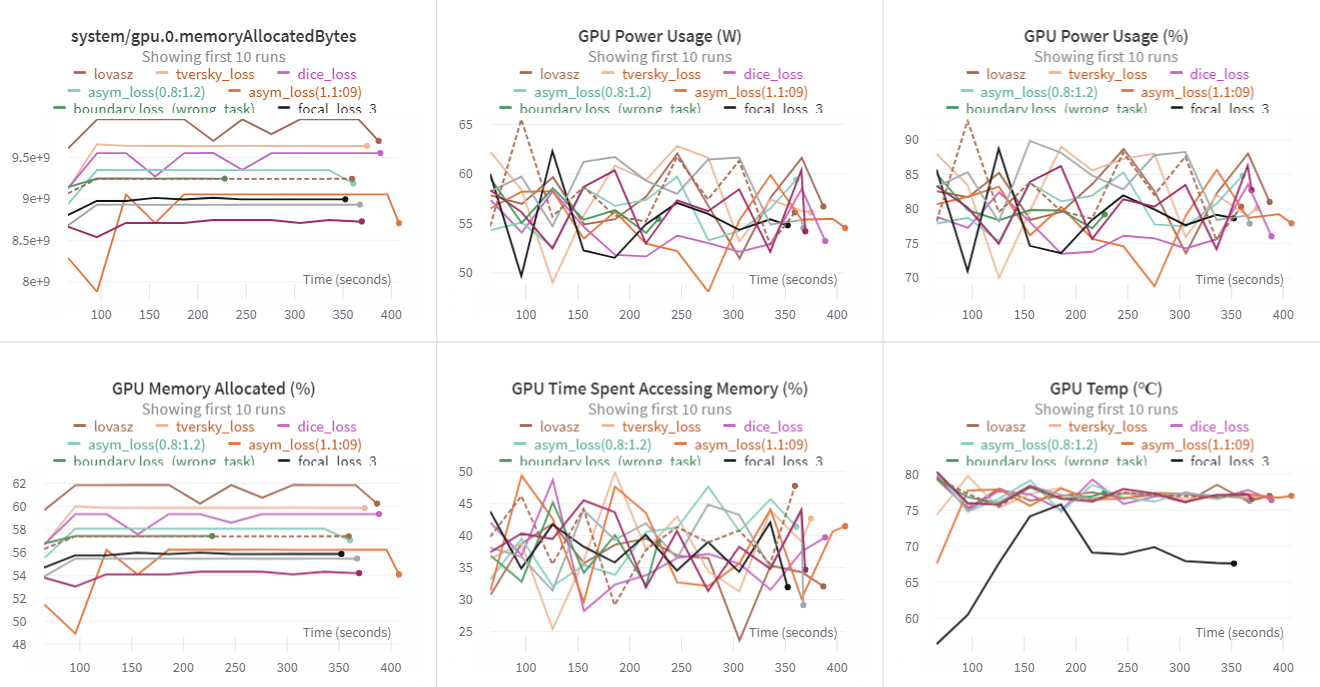

#### WandB report

[Link to interactive WandB report](https://wandb.ai/dimildizio/Semantic_segmentation_dermoscopic/reports/SegNet_total--Vmlldzo2MDE3ODE1)

## Unet

**Unet** - is what you get when trying to marry SegNet's encoder-decoder structure with ResNet Skip-Connections.
It has been introduce in 2015 in [this article](https://arxiv.org/abs/1505.04597). The name was chosen since the network architecture resemple letter 'U' (or a parabola).


![picture](https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Convolutions/data/unet_img1.png)

source: [U-Net Image Segmentation in Keras by Margaret Maynard-Reid](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)


Introducing skip-connection addresses information loss due to gradient vanishing and downsampling thus allowing the network to catch both local and global context.

![unet-architecture](https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Convolutions/data/unet_img2.png)

source: [original U-Net: Convolutional Networks for Biomedical Image Segmentation paper at arxiv by Olaf Ronneberger, Philipp Fischer, Thomas Brox](https://arxiv.org/abs/1505.04597)

### Unet key-components

#### Encoders

Left side of unet is a number on Convolution andMaxPool layers that progressively reduce resolution and increase the number of out_channels. This extracts hierarchical features from input.


#### Bottleneck

In the middle of the structure, between Encoders and Decoders there is a bottleneck that tries to capture the most abstract details.

#### Decoders

The right side of unet is a number of upsamples and combining them with feature maps from corresponding encoders through skip-connections (hello, ResNet). This helps retain the information lost in encoding process. Basically that's just concatenation.


#### Skip-Connections

The most defining part of Unet. As stated above - ocncatenation of encoder outputs with the same level (actually the result of decoder level-1) of decoder. Fights gradient vanishing allowing grads flow from decoder to encoder (backprop).

#### Final layer

1x1 convolution usually followed by activation function (softmax or sigmoid), due to how our custom loss functions are structured, we could just use logits.   

### Unet model

In [140]:
class UNet(nn.Module):
  def __init__(self, inch=3):
    super().__init__()

    # encoder (downsampling)
    # Each enc_conv/dec_conv block should look like this:
    # nn.Sequential(
    #     nn.Conv2d(...),
    #     ... (2 or 3 conv layers with relu and batchnorm),
    # )
    self.pool = self.get_pool()
    self.upsample = self.get_up()

    ouch_0 = CFG.out_channels # 64
    ouch_1 = ouch_0 * 2      # 128
    ouch_2 = ouch_1 * 2      # 256
    ouch_3 = ouch_2 * 2      # 512
    ouch_4 = ouch_3 * 2      # 1024

    # encoder (downsampling)
    self.enc_conv_0 = self.conv_down(inch, ouch_0)
    self.enc_conv_1 = self.conv_down(ouch_0, ouch_1)
    self.enc_conv_2 = self.conv_down(ouch_1, ouch_2)
    self.enc_conv_3 = self.conv_down(ouch_2, ouch_3)

    self.bottleneck = self.conv_bottleneck(ouch_3)

    # decoder (upsampling)
    self.dec_conv_0 = self.conv_up(ouch_4, ouch_3)
    self.dec_conv_1 = self.conv_up(ouch_3, ouch_2)
    self.dec_conv_2 = self.conv_up(ouch_2, ouch_1)
    self.dec_conv_3 = self.conv_last(ouch_1, ouch_0)


  def forward(self, x):
    # encoding
    enc_0, enpool_0 = self.en_pool(self.enc_conv_0, x)
    enc_1, enpool_1 = self.en_pool(self.enc_conv_1, enpool_0)
    enc_2, enpool_2 = self.en_pool(self.enc_conv_2, enpool_1)
    enc_3, enpool_3 = self.en_pool(self.enc_conv_3, enpool_2)
    # bottleneck
    b = self.bottleneck(enpool_3)
    # decoding
    dec_0 = self.skip_concat(self.dec_conv_0, b, enc_3)
    dec_1 = self.skip_concat(self.dec_conv_1, dec_0, enc_2)
    dec_2 = self.skip_concat(self.dec_conv_2, dec_1, enc_1)
    dec_3 = self.skip_concat(self.dec_conv_3, dec_2, enc_0)
    return dec_3


  def en_pool(self, encoder, x):
    result_enc = encoder(x)
    pooled = self.pool(result_enc)
    return result_enc, pooled


  def skip_concat(self, decoder, to_decode, encoded):
    upsampled = self.upsample(to_decode)
    skip_con = torch.cat((upsampled, encoded), dim = 1)
    return decoder(skip_con)


  def conv_down(self, inch, ouch):
    conv = nn.Sequential(nn.Conv2d(in_channels=inch, out_channels=ouch,
                                   kernel_size=3, padding=1),
                         nn.BatchNorm2d(ouch, momentum=CFG.batch_norm_momentum),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=ouch, out_channels=ouch,
                                   kernel_size=3, padding=1),
                         nn.BatchNorm2d(ouch, momentum=CFG.batch_norm_momentum),
                         nn.ReLU())
    return conv


  def conv_up(self, inch, ouch):
    #after this func upsampling would double last dimensions of this output
    temp_ouch = ouch // 2
    conv = nn.Sequential(nn.Conv2d(in_channels=inch, out_channels=ouch,
                                   kernel_size=3, padding=1),
                         nn.BatchNorm2d(ouch, momentum=CFG.batch_norm_momentum),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=ouch, out_channels=temp_ouch,
                                   kernel_size=3, padding=1),
                         nn.BatchNorm2d(temp_ouch, momentum=CFG.batch_norm_momentum),
                         nn.ReLU())
    return conv


  def conv_bottleneck(self, inch):
    bouch = inch * 2
    bottle = nn.Sequential(nn.Conv2d(in_channels=inch,
                                     out_channels=bouch,
                                     kernel_size=3,
                                     padding=1),
                            nn.BatchNorm2d(bouch, momentum=CFG.batch_norm_momentum),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=bouch,
                                      out_channels=inch,
                                      kernel_size=3,
                                      padding=1),
                            nn.BatchNorm2d(inch, momentum=CFG.batch_norm_momentum),
                            nn.ReLU())
    return bottle



  def conv_last(self, inch, ouch):
    conv = nn.Sequential(nn.Conv2d(in_channels=inch, out_channels=ouch,
                                   kernel_size=3, padding=1),
                         nn.BatchNorm2d(ouch, momentum=CFG.batch_norm_momentum),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=ouch, out_channels=ouch,
                                   kernel_size=3, padding=1),
                         nn.BatchNorm2d(ouch, momentum=CFG.batch_norm_momentum),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=ouch, out_channels=1,
                                   kernel_size=1))
    return conv


  def get_pool(self):
    return nn.MaxPool2d(kernel_size=2)


  def get_up(self):
    return nn.Upsample(scale_factor=2)

#### Model architecture

In [141]:
print(summary(UNet(), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

#### Train unet1

bce_loss

In [ ]:
try:
  del_gpu()
  del model
except Exception as e:
  print(e)

CFG.loss = lambda: 'unet1_bce_loss'
model = UNet().to(CFG.device())
best_model, unet1 = train(model, num_stab_bce_loss, data_train, data_val)